## Temporal Fusion Transformer Test V2

Using device: cpu


/var/folders/31/b1v52j156gbfz83pmrnth3jc0000gn/T/ipykernel_94184/1875478185.py:76: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['price_ma5'] = df['price'].rolling(window=5).mean().fillna(method='bfill')
/var/folders/31/b1v52j156gbfz83pmrnth3jc0000gn/T/ipykernel_94184/1875478185.py:77: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['price_ma20'] = df['price'].rolling(window=20).mean().fillna(method='bfill')
/var/folders/31/b1v52j156gbfz83pmrnth3jc0000gn/T/ipykernel_94184/1875478185.py:78: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['rsi'] = calculate_rsi(df['price'], 14).fillna(method='bfill')


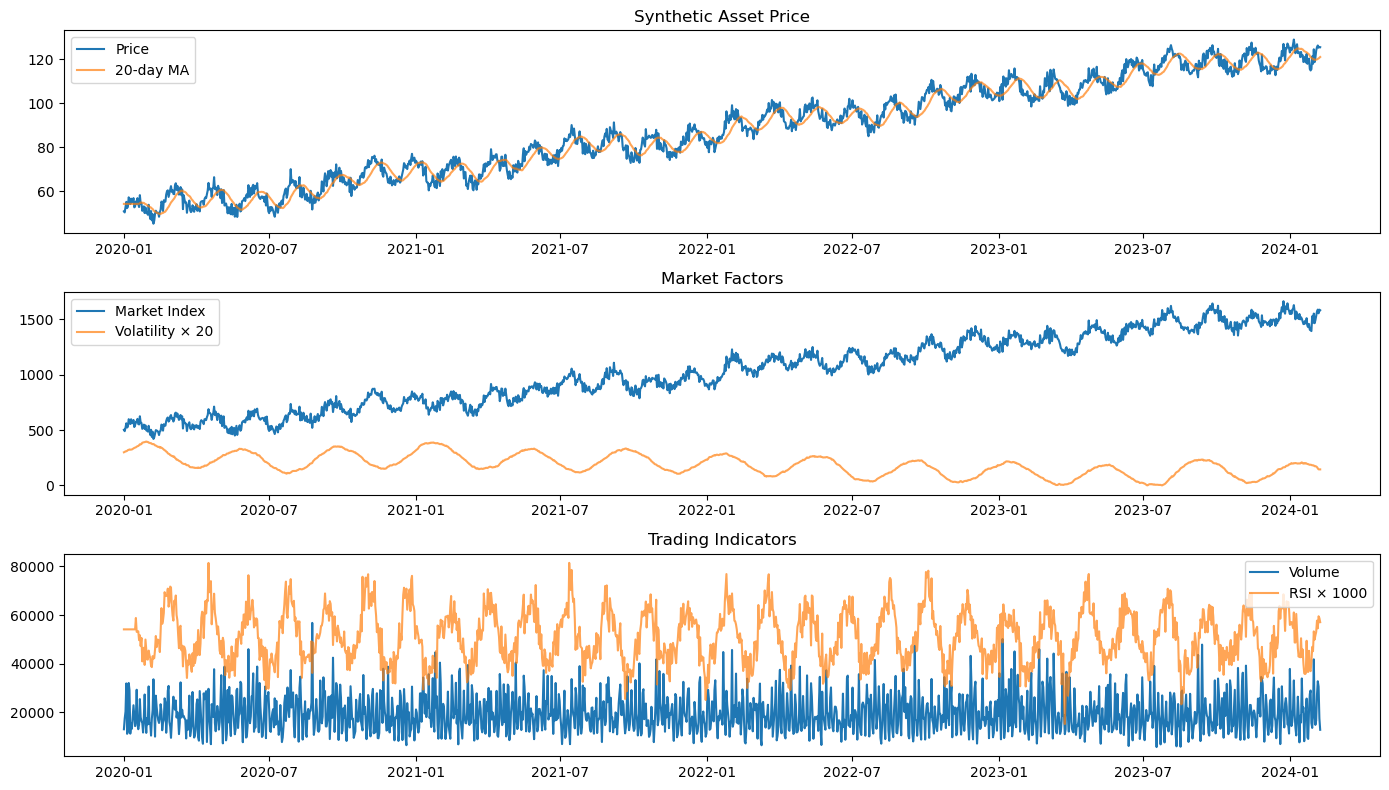

Training set size: 1172 sequences
Test set size: 294 sequences
Each sequence has 30 historical timesteps and predicts 5 future timesteps


TypeError: TemporalFusionTransformer.__init__() got an unexpected keyword argument 'num_static_vars'

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from datetime import datetime, timedelta

# Import your TFT model
# Adjust the import path as needed
from models.tft_v2 import TemporalFusionTransformer

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create synthetic financial data
def generate_financial_data(n_samples=1000, freq='D'):
    """Generate synthetic financial time series with trend, seasonality, and exogenous factors"""
    date_range = pd.date_range(start='2020-01-01', periods=n_samples, freq=freq)
    
    # Time index
    t = np.arange(n_samples)
    
    # Price components
    trend = 50 + 0.05 * t  # Upward trend
    seasonality = 5 * np.sin(2 * np.pi * t / 50) + 3 * np.sin(2 * np.pi * t / 250)  # Multiple seasonal patterns
    noise = np.random.normal(scale=2, size=n_samples)
    
    # Price
    price = trend + seasonality + noise
    
    # Generate exogenous variables
    # 1. Market index - correlated with price but with its own pattern
    market_index = 1000 + 0.03 * t + 30 * np.sin(2 * np.pi * t / 75) + np.random.normal(scale=10, size=n_samples)
    market_index = market_index * (1 + 0.3 * (price - np.mean(price)) / np.std(price))
    
    # 2. Trading volume - higher on volatile days
    volume = 10000 + 5000 * np.sin(2 * np.pi * t / 5) + 2000 * np.random.gamma(2, 1, size=n_samples)
    volume = volume * (1 + 0.5 * np.abs(noise) / np.std(noise))
    
    # 3. Volatility index
    volatility = 15 + 5 * np.sin(2 * np.pi * t / 120) + 3 * np.cumsum(np.random.normal(scale=0.05, size=n_samples))
    volatility = np.abs(volatility)
    
    # 4. Interest rate (slowly changing)
    interest_rate = 2 + 1 * np.sin(2 * np.pi * t / 500) + 0.5 * np.cumsum(np.random.normal(scale=0.01, size=n_samples))
    
    # 5. Day of week effect (categorical)
    weekday = np.array([d.weekday() for d in date_range])
    
    # 6. Month effect (categorical)
    month = np.array([d.month for d in date_range])
    
    # Create DataFrame
    df = pd.DataFrame({
        'date': date_range,
        'price': price,
        'market_index': market_index,
        'volume': volume,
        'volatility': volatility,
        'interest_rate': interest_rate,
        'weekday': weekday,
        'month': month
    })
    
    # Add some technical indicators
    df['price_ma5'] = df['price'].rolling(window=5).mean().fillna(method='bfill')
    df['price_ma20'] = df['price'].rolling(window=20).mean().fillna(method='bfill')
    df['rsi'] = calculate_rsi(df['price'], 14).fillna(method='bfill')
    
    return df

# Calculate RSI (Relative Strength Index)
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0).rolling(window=window).mean()
    loss = -delta.clip(upper=0).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Generate the dataset
df = generate_financial_data(n_samples=1500)

# Plot the generated data
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(df['date'], df['price'], label='Price')
plt.plot(df['date'], df['price_ma20'], label='20-day MA', alpha=0.7)
plt.legend()
plt.title('Synthetic Asset Price')

plt.subplot(3, 1, 2)
plt.plot(df['date'], df['market_index'], label='Market Index')
plt.plot(df['date'], df['volatility'] * 20, label='Volatility × 20', alpha=0.7)  # Scaled for visibility
plt.legend()
plt.title('Market Factors')

plt.subplot(3, 1, 3)
plt.plot(df['date'], df['volume'], label='Volume')
plt.plot(df['date'], df['rsi'] * 1000, label='RSI × 1000', alpha=0.7)  # Scaled for visibility
plt.legend()
plt.title('Trading Indicators')

plt.tight_layout()
plt.show()

# Prepare data for TFT
# We'll use:
# - Static variables: None for this example
# - Past inputs: price history, technical indicators
# - Future inputs: known calendar features (weekday, month)

# Preprocess data
def preprocess_data(df):
    """Scale and prepare data for the TFT model"""
    
    # Create date features
    df['day_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Create scaled versions of numerical columns
    price_scaler = StandardScaler()
    market_scaler = StandardScaler()
    volume_scaler = StandardScaler()
    other_scaler = StandardScaler()
    
    # Price-related features
    price_cols = ['price', 'price_ma5', 'price_ma20']
    df[['price_scaled', 'price_ma5_scaled', 'price_ma20_scaled']] = price_scaler.fit_transform(df[price_cols])
    
    # Market features
    market_cols = ['market_index', 'volatility']
    df[['market_index_scaled', 'volatility_scaled']] = market_scaler.fit_transform(df[market_cols])
    
    # Volume
    df['volume_scaled'] = volume_scaler.fit_transform(df[['volume']])
    
    # Other features
    other_cols = ['interest_rate', 'rsi']
    df[['interest_rate_scaled', 'rsi_scaled']] = other_scaler.fit_transform(df[other_cols])
    
    return df, {
        'price': price_scaler,
        'market': market_scaler,
        'volume': volume_scaler,
        'other': other_scaler
    }

# Preprocess the data
df, scalers = preprocess_data(df)

# Define parameters
lookback_period = 30  # 30 days history
forecast_horizon = 5  # Predict 5 days ahead

# Create sequences
def create_sequences(df, lookback, horizon):
    """Create sequences for time series forecasting"""
    X_past_price = []  # Past price & indicators
    X_past_market = []  # Past market data
    X_future_calendar = []  # Future calendar features
    
    y = []  # Target prices
    
    for i in range(len(df) - lookback - horizon + 1):
        # Past data
        past_data = df.iloc[i:i+lookback]
        
        # Past price features
        past_price_features = past_data[['price_scaled', 'price_ma5_scaled', 'price_ma20_scaled', 'rsi_scaled']].values
        X_past_price.append(past_price_features)
        
        # Past market features
        past_market_features = past_data[['market_index_scaled', 'volatility_scaled', 'volume_scaled', 'interest_rate_scaled']].values
        X_past_market.append(past_market_features)
        
        # Future data - known calendar features
        future_data = df.iloc[i+lookback:i+lookback+horizon]
        future_calendar_features = future_data[['day_sin', 'day_cos', 'month_sin', 'month_cos']].values
        X_future_calendar.append(future_calendar_features)
        
        # Target - future prices
        target_prices = future_data['price_scaled'].values
        y.append(target_prices)
    
    return (
        torch.tensor(np.array(X_past_price), dtype=torch.float32),
        torch.tensor(np.array(X_past_market), dtype=torch.float32),
        torch.tensor(np.array(X_future_calendar), dtype=torch.float32),
        torch.tensor(np.array(y), dtype=torch.float32)
    )

# Create sequences
X_past_price, X_past_market, X_future_calendar, y = create_sequences(df, lookback_period, forecast_horizon)

# Train/test split (80/20)
train_size = int(0.8 * len(X_past_price))
test_size = len(X_past_price) - train_size

X_past_price_train, X_past_price_test = X_past_price[:train_size], X_past_price[train_size:]
X_past_market_train, X_past_market_test = X_past_market[:train_size], X_past_market[train_size:]
X_future_calendar_train, X_future_calendar_test = X_future_calendar[:train_size], X_future_calendar[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training set size: {train_size} sequences")
print(f"Test set size: {test_size} sequences")
print(f"Each sequence has {lookback_period} historical timesteps and predicts {forecast_horizon} future timesteps")

# Setup TFT model
encoder_input_sizes = [4, 4]  # Past price features, past market features
decoder_input_sizes = [4]     # Future calendar features
hidden_dim = 64
num_heads = 4
dropout = 0.1
num_lstm_layers = 2

model = TemporalFusionTransformer(
    num_static_vars=0,
    num_future_vars=1,
    num_past_vars=2,
    static_input_sizes=[],
    encoder_input_sizes=encoder_input_sizes,
    decoder_input_sizes=decoder_input_sizes,
    hidden_dim=hidden_dim,
    lstm_layers=num_lstm_layers,
    lstm_dropout=dropout,
    dropout=dropout,
    num_heads=num_heads,
    forecast_horizon=forecast_horizon,
    backcast_length=lookback_period,
    output_dim=1,
    quantiles=[0.1, 0.5, 0.9]
).to(device)

# Training function
def train_model(model, epochs=50, batch_size=32, patience=10):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)
    
    # Quantile loss function
    def quantile_loss(y_pred, y_true, quantiles):
        losses = []
        for i, q in enumerate([0.1, 0.5, 0.9]):
            errors = y_true - y_pred[:, :, :, i]
            losses.append(torch.max((q - 1) * errors, q * errors).mean())
        return torch.mean(torch.stack(losses))
    
    # For tracking
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    
    # Progress trackers for plotting
    epoch_progress = []
    batch_progress = []
    batch_loss_values = []
    
    # Create mini-batches
    def get_batches(x_past_price, x_past_market, x_future_calendar, y_target, batch_size):
        for i in range(0, len(x_past_price), batch_size):
            yield (
                x_past_price[i:i+batch_size].to(device),
                x_past_market[i:i+batch_size].to(device),
                x_future_calendar[i:i+batch_size].to(device),
                y_target[i:i+batch_size].to(device)
            )
    
    model.train()
    total_batches = len(X_past_price_train) // batch_size + (1 if len(X_past_price_train) % batch_size != 0 else 0)
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        batch_count = 0
        
        # Shuffle training data
        indices = torch.randperm(len(X_past_price_train))
        X_past_price_train_shuffled = X_past_price_train[indices]
        X_past_market_train_shuffled = X_past_market_train[indices]
        X_future_calendar_train_shuffled = X_future_calendar_train[indices]
        y_train_shuffled = y_train[indices]
        
        # Training loop
        for batch_idx, (x_past_price_batch, x_past_market_batch, x_future_calendar_batch, y_batch) in enumerate(
            get_batches(X_past_price_train_shuffled, X_past_market_train_shuffled, 
                       X_future_calendar_train_shuffled, y_train_shuffled, batch_size)
        ):
            optimizer.zero_grad()
            
            # Prepare encoder/decoder inputs as lists
            encoder_inputs = [x_past_price_batch, x_past_market_batch]
            decoder_inputs = [x_future_calendar_batch]
            
            # Forward pass
            y_batch = y_batch.unsqueeze(-1)  # Add feature dimension to match model output
            predictions = model(static_inputs=None, encoder_inputs=encoder_inputs, decoder_inputs=decoder_inputs)
            
            # Calculate loss
            loss = quantile_loss(predictions, y_batch, [0.1, 0.5, 0.9])
            
            # Backward and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # Track progress
            epoch_loss += loss.item()
            batch_count += 1
            
            # For plotting
            epoch_progress.append(epoch + batch_idx/total_batches)
            batch_progress.append(epoch * total_batches + batch_idx)
            batch_loss_values.append(loss.item())
            
            # Print batch progress every few batches
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{total_batches}, Loss: {loss.item():.4f}")
        
        # Calculate validation loss
        model.eval()
        val_loss = 0.0
        val_batch_count = 0
        
        with torch.no_grad():
            for x_past_price_batch, x_past_market_batch, x_future_calendar_batch, y_batch in get_batches(
                X_past_price_test, X_past_market_test, X_future_calendar_test, y_test, batch_size
            ):
                # Prepare encoder/decoder inputs as lists
                encoder_inputs = [x_past_price_batch, x_past_market_batch]
                decoder_inputs = [x_future_calendar_batch]
                
                # Forward pass
                y_batch = y_batch.unsqueeze(-1)
                predictions = model(static_inputs=None, encoder_inputs=encoder_inputs, decoder_inputs=decoder_inputs)
                
                # Calculate loss
                loss = quantile_loss(predictions, y_batch, [0.1, 0.5, 0.9])
                val_loss += loss.item()
                val_batch_count += 1
        
        avg_train_loss = epoch_loss / batch_count
        avg_val_loss = val_loss / val_batch_count
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Track best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_tft_model.pth')
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break
        
        # Switch back to training mode
        model.train()
    
    # Load best model
    model.load_state_dict(torch.load('best_tft_model.pth'))
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_epoch': best_epoch,
        'epoch_progress': epoch_progress,
        'batch_progress': batch_progress,
        'batch_loss_values': batch_loss_values
    }

# Train the model
history = train_model(model, epochs=50, batch_size=32, patience=10)

# Plot training curves
plt.figure(figsize=(15, 10))

# Training loss curve
plt.subplot(2, 1, 1)
plt.plot(history['train_losses'], label='Training Loss')
plt.plot(history['val_losses'], label='Validation Loss')
plt.axvline(x=history['best_epoch'], color='r', linestyle='--', label=f'Best Model (Epoch {history["best_epoch"]+1})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TFT Training and Validation Loss')
plt.legend()
plt.grid(True)

# Batch loss curve
plt.subplot(2, 1, 2)
plt.plot(history['batch_progress'], history['batch_loss_values'], alpha=0.3, label='Batch Loss')
# Add a smoothed version
window_size = 20
if len(history['batch_loss_values']) > window_size:
    smoothed = np.convolve(history['batch_loss_values'], np.ones(window_size)/window_size, mode='valid')
    plt.plot(history['batch_progress'][window_size-1:], smoothed, label=f'Moving Avg (window={window_size})')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('TFT Training Loss by Batch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate the model
def evaluate_model(model, X_past_price, X_past_market, X_future_calendar, y_true, scalers):
    model.eval()
    predictions = []
    actual = []
    
    batch_size = 64
    
    with torch.no_grad():
        for i in range(0, len(X_past_price), batch_size):
            # Prepare batches
            x_past_price_batch = X_past_price[i:i+batch_size].to(device)
            x_past_market_batch = X_past_market[i:i+batch_size].to(device)
            x_future_calendar_batch = X_future_calendar[i:i+batch_size].to(device)
            y_batch = y_true[i:i+batch_size]
            
            # Prepare inputs as lists
            encoder_inputs = [x_past_price_batch, x_past_market_batch]
            decoder_inputs = [x_future_calendar_batch]
            
            # Forward pass - get all quantiles
            output = model(static_inputs=None, encoder_inputs=encoder_inputs, decoder_inputs=decoder_inputs)
            
            # Extract median prediction (quantile 0.5 is index 1)
            median_preds = output[:, :, 0, 1].cpu()  # [batch, horizon, feature=0, quantile=0.5]
            
            # Store predictions and actual values
            predictions.append(median_preds)
            actual.append(y_batch)
    
    # Concatenate all batches
    predictions = torch.cat(predictions, dim=0).numpy()
    actual = torch.cat(actual, dim=0).numpy()
    
    # Inverse transform to get original scale
    predictions_orig = scalers['price'].inverse_transform(predictions.reshape(-1, 1)).reshape(predictions.shape)
    actual_orig = scalers['price'].inverse_transform(actual.reshape(-1, 1)).reshape(actual.shape)
    
    return predictions, actual, predictions_orig, actual_orig

# Evaluate on train and test sets
train_preds, train_actual, train_preds_orig, train_actual_orig = evaluate_model(
    model, X_past_price_train, X_past_market_train, X_future_calendar_train, y_train, scalers
)

test_preds, test_actual, test_preds_orig, test_actual_orig = evaluate_model(
    model, X_past_price_test, X_past_market_test, X_future_calendar_test, y_test, scalers
)

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true.flatten(), y_pred.flatten())
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    
    # Mean absolute percentage error
    mape = np.mean(np.abs((y_true.flatten() - y_pred.flatten()) / y_true.flatten())) * 100
    
    # Directional accuracy (for financial data)
    y_true_diff = np.diff(y_true, axis=1)
    y_pred_diff = np.diff(y_pred, axis=1)
    directional_acc = np.mean((y_true_diff * y_pred_diff) > 0) * 100
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape,
        'Direction Accuracy': directional_acc
    }

# Calculate metrics for train and test sets
train_metrics = calculate_metrics(train_actual_orig, train_preds_orig)
test_metrics = calculate_metrics(test_actual_orig, test_preds_orig)

# Print metrics
print("\nTraining Set Metrics:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nTest Set Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot forecasts
def plot_predictions(actual, predictions, split_idx, forecast_horizon=5, num_samples=100):
    """Plot predictions vs actual values"""
    plt.figure(figsize=(15, 8))
    
    # Select a subset of data points for clarity
    indices = np.linspace(0, len(actual) - 1, num_samples, dtype=int)
    
    # Create x-axis with appropriate time indexing
    x = np.array(list(range(len(indices) * forecast_horizon)))
    
    # Initialize arrays for actual and predicted values
    y_true_plot = np.zeros(len(indices) * forecast_horizon)
    y_pred_plot = np.zeros(len(indices) * forecast_horizon)
    
    # Populate arrays
    for i, idx in enumerate(indices):
        for h in range(forecast_horizon):
            true_idx = i * forecast_horizon + h
            if true_idx < len(y_true_plot):
                y_true_plot[true_idx] = actual[idx, h]
                y_pred_plot[true_idx] = predictions[idx, h]
    
    # Split index for plot (convert from sequence index to plot index)
    plot_split_idx = (split_idx / len(actual)) * len(y_true_plot)
    
    # Plot
    plt.plot(x, y_true_plot, 'b-', label='True Price', alpha=0.7)
    plt.plot(x, y_pred_plot, 'r--', label='Predicted Price', alpha=0.7)
    
    # Draw vertical line for train/test split
    plt.axvline(x=plot_split_idx, color='green', linestyle='--', label='Train/Test Split')
    
    plt.title('Asset Price - True vs Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Combine train and test data for a continuous plot
all_actual = np.vstack([train_actual_orig, test_actual_orig])
all_preds = np.vstack([train_preds_orig, test_preds_orig])

# Plot predictions
plot_predictions(all_actual, all_preds, train_size, forecast_horizon=forecast_horizon)

# Visualize attention weights
def visualize_attention_weights(model, sample_idx=0):
    """Visualize attention weights for a sample input"""
    model.eval()
    
    with torch.no_grad():
        # Prepare inputs for a single sample
        x_past_price = X_past_price_test[sample_idx:sample_idx+1].to(device)
        x_past_market = X_past_market_test[sample_idx:sample_idx+1].to(device)
        x_future_calendar = X_future_calendar_test[sample_idx:sample_idx+1].to(device)
        
        # Prepare inputs as lists
        encoder_inputs = [x_past_price, x_past_market]
        decoder_inputs = [x_future_calendar]
        
        # Extract attention weights (hook the attention layer)
        attention_weights = None
        
        def hook_fn(module, input, output):
            nonlocal attention_weights
            # output is (output, attention_weights)
            attention_weights = output[1]
        
        # Register a forward hook on the attention layer
        hook = model.attention.register_forward_hook(hook_fn)
        
        # Forward pass
        _ = model(static_inputs=None, encoder_inputs=encoder_inputs, decoder_inputs=decoder_inputs)
        
        # Remove the hook
        hook.remove()
        
        # Process attention weights
        if attention_weights is not None:
            # Average across attention heads
            avg_attn = attention_weights.mean(dim=1).squeeze(0).cpu().numpy()
            
            # Plot attention heatmap
            plt.figure(figsize=(10, 8))
            sns.heatmap(
                avg_attn, 
                cmap='viridis',
                xticklabels=[f"t-{lookback_period-i}" for i in range(lookback_period)] + [f"t+{i+1}" for i in range(forecast_horizon)],
                yticklabels=[f"t-{lookback_period-i}" for i in range(lookback_period)] + [f"t+{i+1}" for i in range(forecast_horizon)]
            )
            plt.title('Self-Attention Weights Heatmap')
            plt.xlabel('Key Positions')
            plt.ylabel('Query Positions')
            plt.tight_layout()
            plt.show()

# Try to visualize attention weights if the model has the attention layer exposed
try:
    visualize_attention_weights(model)
except Exception as e:
    print(f"Could not visualize attention weights: {e}")
    print("Continuing with other visualizations...")

# # Visualize variable selection weights
# def visualize_variable_selection(model, num_samples=5):
#     """Visualize variable selection weights for a few samples"""
#     model.eval()
    
#     with torch.no_grad():
#         # Prepare inputs for a few samples
#         sample_indices = np.random.choice(len(X_past_price_test), size=num_samples, replace=False)
        
#         encoder_vsn_weights_samples = []
#         decoder_vsn_weights_samples = []
        
#         for idx in sample_indices:
#             # Prepare inputs
#             x_past_price = X_past_price_test[idx:idx+1].to(device)
#             x_past_market = X_past_market_test[idx:idx+1].to(device)
#             x_future_calendar = X_future_calendar_test[idx:idx+1].to(device)
            
#             # Prepare inputs as lists
#             encoder_inputs = [x_past_price, x_past_market]
#             decoder_inputs = [x_future_calendar]
            
#             # Extract VSN weights (we need to modify the model or use hooks)
#             encoder_vsn_weights = None
#             decoder_vsn_weights = None
            
#             def encoder_hook_fn(module, input, output):
#                 nonlocal encoder_vsn_weights
#                 # output is typically (combined, weights)
#                 encoder_vsn_weights = output[1]
            
#             def decoder_hook_fn(module, input, output):
#                 nonlocal decoder_vsn_weights
#                 decoder_vsn_weights = output[1]
            
#             # Register hooks on VSN modules
#             encoder_hook = model.encoder_vsn.register_forward_hook(encoder_hook_fn)
#             decoder_hook = model.decoder_vsn.register_forward_hook(decoder_hook_fn)
            
#             # Forward pass
#             _ = model(static_inputs=None, encoder_inputs=encoder_inputs, decoder_inputs=decoder_inputs)
            
#             # Remove hooks
#             encoder_hook.remove()
#             decoder_hook.remove()
            
#             # Collect weights
#             if encoder_vsn_weights is not None:
#                 encoder_vsn_weights_samples.append(encoder_vsn_weights.squeeze().cpu().numpy())
            
#             if decoder_vsn_weights is not None:
#                 decoder_vsn_weights_samples.append(decoder_vsn_weights.squeeze().cpu().numpy())
        
#         # Plot variable selection weights
#         if encoder_vsn_weights_samples and encoder_vsn_weights_samples[0].size > 0:

Using device: cpu


/var/folders/31/b1v52j156gbfz83pmrnth3jc0000gn/T/ipykernel_94184/2302105882.py:88: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')


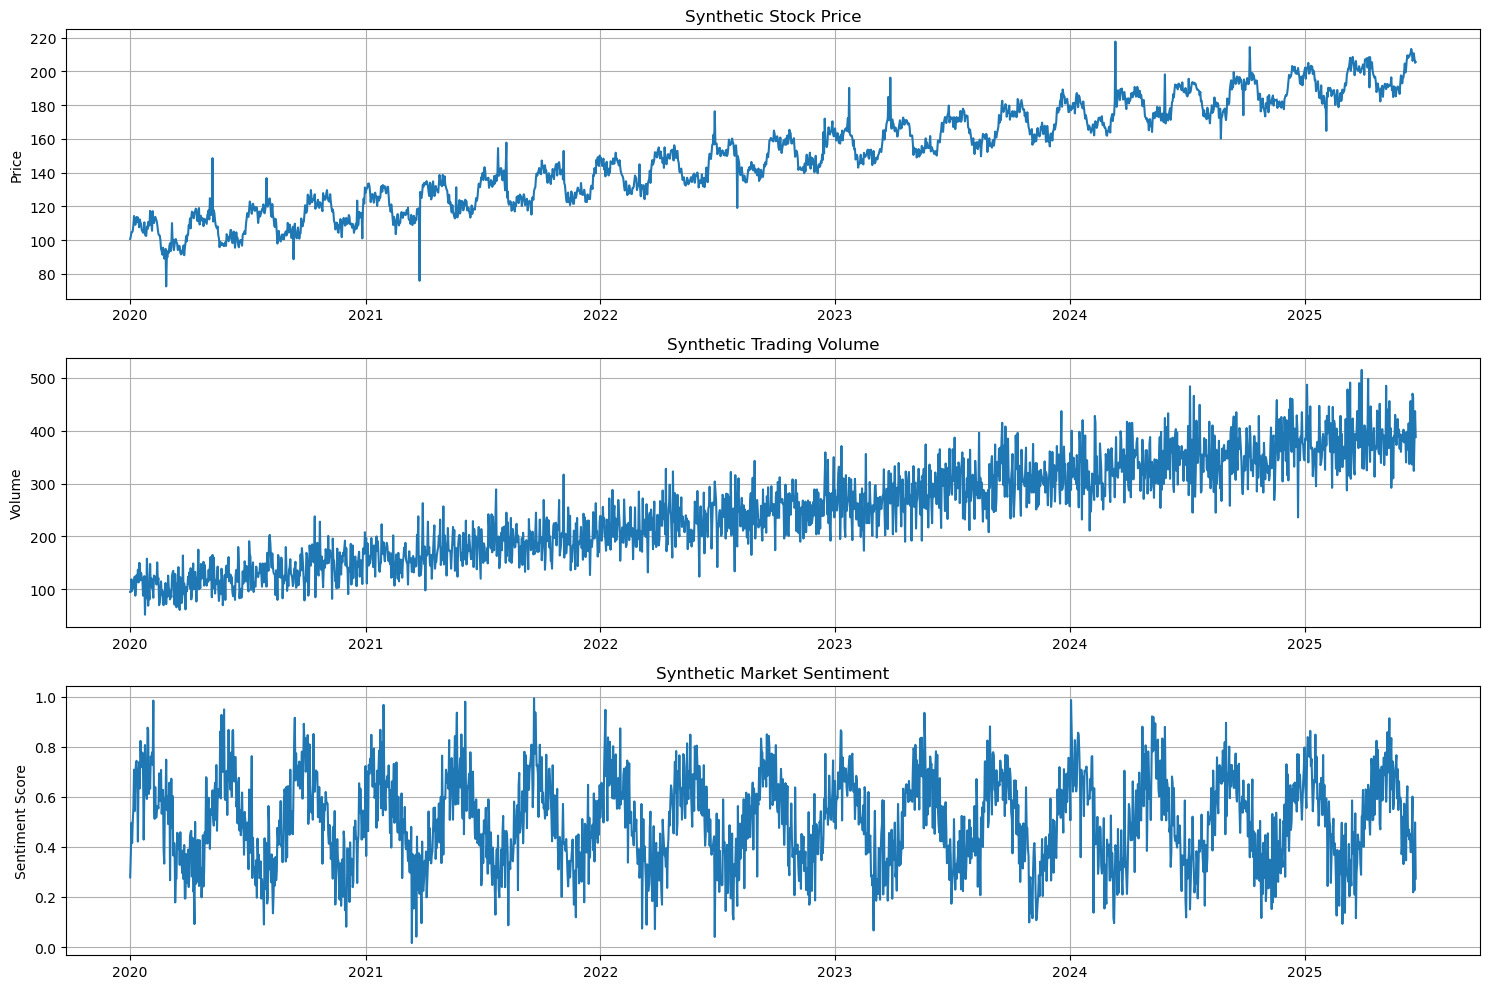

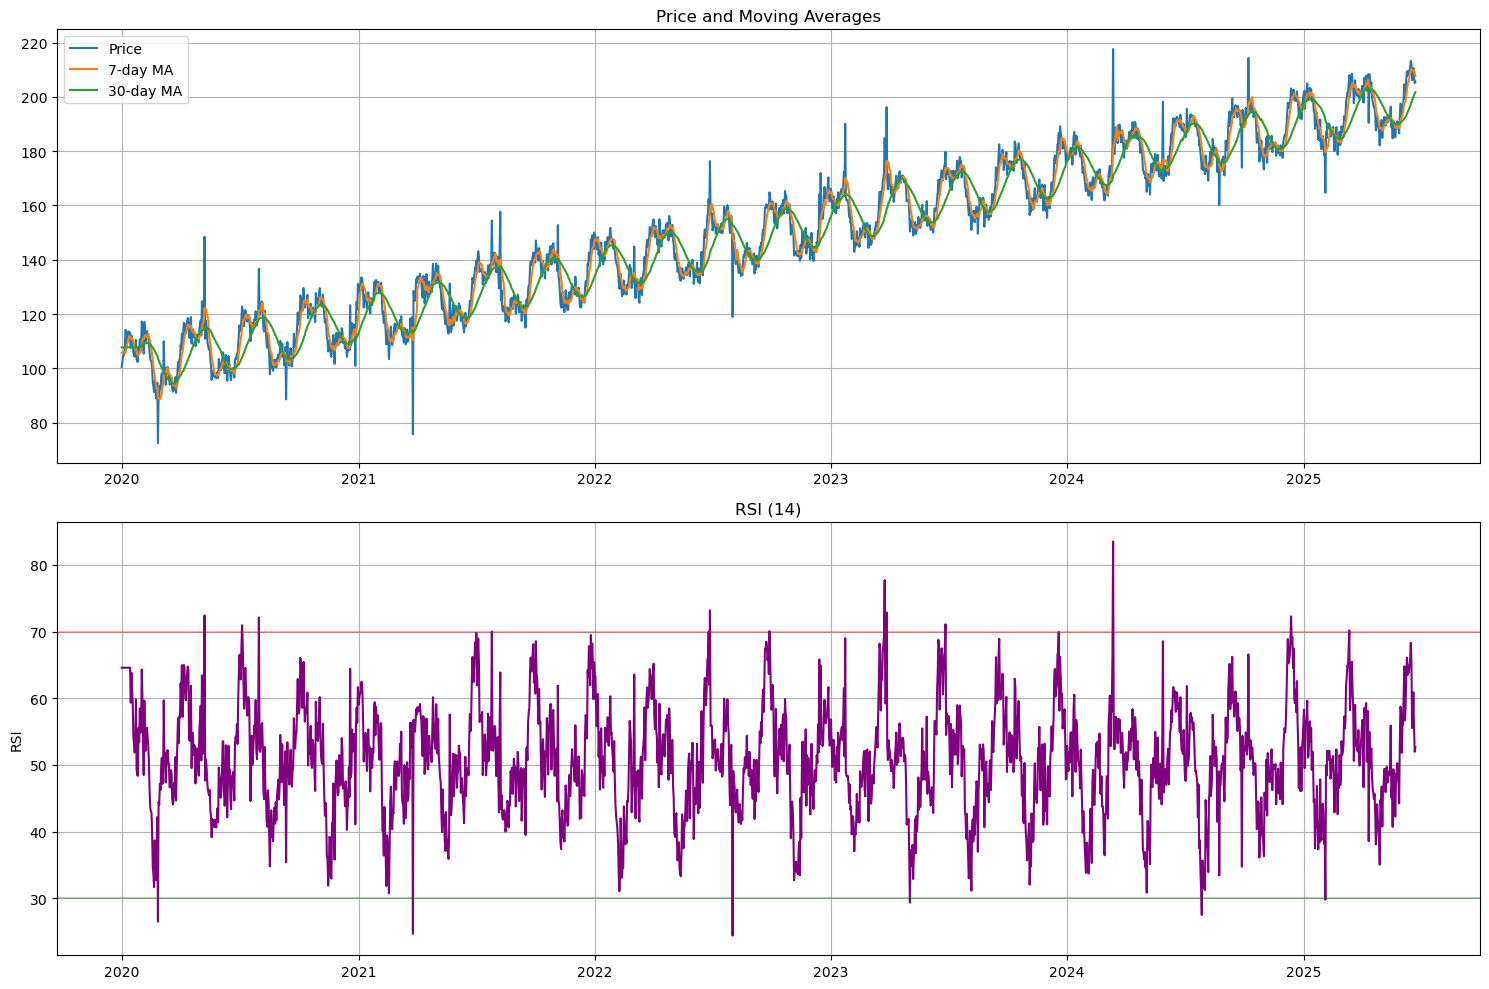

Train data shape: torch.Size([1571, 7])
Test data shape: torch.Size([393, 7])
Encoder input 0 shape: torch.Size([1571, 30, 22])
Encoder input 1 shape: torch.Size([1571, 30, 7])
Decoder input 0 shape: torch.Size([1571, 7, 22])


TypeError: TemporalFusionTransformer.__init__() got an unexpected keyword argument 'num_static_vars'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from datetime import datetime, timedelta

# Import our TFT implementation
# Assuming you saved the TFT code in a file called temporal_fusion_transformer.py
from models.tft_v2 import TemporalFusionTransformer

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ====================== 1. Generate Synthetic Financial Data ======================

def generate_synthetic_financial_data(n_samples=2000, start_date="2020-01-01"):
    """Generate synthetic stock price data with trends, seasonality, and random events."""
    dates = pd.date_range(start=start_date, periods=n_samples)
    t = np.arange(n_samples)
    
    # Base price with trend
    price = 100 + 0.05 * t
    
    # Add weekly seasonality (5-day pattern)
    weekly = 2 * np.sin(2 * np.pi * t / 5)
    
    # Add monthly seasonality
    monthly = 5 * np.sin(2 * np.pi * t / 30)
    
    # Add quarterly seasonality
    quarterly = 10 * np.sin(2 * np.pi * t / 90)
    
    # Random events (occasional price jumps)
    events = np.zeros(n_samples)
    event_indices = np.random.choice(range(n_samples), size=int(n_samples * 0.03), replace=False)
    events[event_indices] = np.random.normal(0, 15, size=len(event_indices))
    
    # Daily noise
    noise = np.random.normal(0, 2, n_samples)
    
    # Combine components
    price = price + weekly + monthly + quarterly + events + noise
    
    # Ensure price is positive
    price = np.maximum(price, 1)
    
    # Create dataframe
    df = pd.DataFrame({
        'date': dates,
        'price': price,
        'day_of_week': dates.dayofweek,
        'day_of_month': dates.day,
        'month': dates.month,
        'is_quarter_end': dates.is_quarter_end.astype(int),
        'is_month_end': dates.is_month_end.astype(int),
        'year': dates.year
    })
    
    # Add technical indicators
    df['ma7'] = df['price'].rolling(window=7).mean()
    df['ma30'] = df['price'].rolling(window=30).mean()
    df['std7'] = df['price'].rolling(window=7).std()
    df['rsi'] = compute_rsi(df['price'], 14)
    
    # Add synthetic trading volume
    volume_base = price * np.random.uniform(0.8, 1.2, n_samples)
    volume_trend = 0.1 * t
    volume_noise = np.random.normal(0, price * 0.2, n_samples)
    df['volume'] = volume_base + volume_trend + volume_noise
    df['volume'] = df['volume'].astype(int)
    
    # Add synthetic sentiment data
    sentiment = 0.5 + 0.2 * np.sin(2 * np.pi * t / 120) + np.random.normal(0, 0.1, n_samples)
    df['sentiment'] = np.clip(sentiment, 0, 1)
    
    # Fill NaN values
    df = df.fillna(method='bfill')
    
    return df

def compute_rsi(prices, window=14):
    """Compute Relative Strength Index."""
    deltas = np.diff(prices)
    seed = deltas[:window+1]
    up = seed[seed >= 0].sum()/window
    down = -seed[seed < 0].sum()/window
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:window] = 100. - 100./(1. + rs)
    
    for i in range(window, len(prices)):
        delta = deltas[i-1]
        if delta > 0:
            upval = delta
            downval = 0
        else:
            upval = 0
            downval = -delta
            
        up = (up * (window - 1) + upval) / window
        down = (down * (window - 1) + downval) / window
        rs = up/down
        rsi[i] = 100. - 100./(1. + rs)
        
    return rsi

# Generate data
df = generate_synthetic_financial_data(n_samples=2000)

# Visualize the generated data
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df['date'], df['price'])
plt.title('Synthetic Stock Price')
plt.ylabel('Price')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(df['date'], df['volume'])
plt.title('Synthetic Trading Volume')
plt.ylabel('Volume')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(df['date'], df['sentiment'])
plt.title('Synthetic Market Sentiment')
plt.ylabel('Sentiment Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# Show technical indicators
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df['date'], df['price'], label='Price')
plt.plot(df['date'], df['ma7'], label='7-day MA')
plt.plot(df['date'], df['ma30'], label='30-day MA')
plt.title('Price and Moving Averages')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df['date'], df['rsi'], color='purple')
plt.axhline(y=70, color='r', linestyle='-', alpha=0.3)
plt.axhline(y=30, color='g', linestyle='-', alpha=0.3)
plt.title('RSI (14)')
plt.ylabel('RSI')
plt.grid(True)

plt.tight_layout()
plt.show()

# ====================== 2. Prepare Data for TFT ======================

# Setting up the forecast parameters
backcast_length = 30  # Number of past time steps to use
forecast_horizon = 7  # Number of future time steps to predict

def prepare_tft_data(df, backcast_length, forecast_horizon):
    """
    Prepare data for TFT model with:
    - Static features: none in this case
    - Past inputs: price history, volume, technical indicators
    - Known future inputs: calendar features
    """
    data_df = df.copy()
    
    # Feature columns
    price_cols = ['price']
    technical_cols = ['ma7', 'ma30', 'std7', 'rsi']
    volume_cols = ['volume']
    sentiment_cols = ['sentiment']
    calendar_cols = ['day_of_week', 'day_of_month', 'month', 'is_quarter_end', 'is_month_end']
    
    # Normalize the data using StandardScaler
    scalers = {}
    for col in price_cols + technical_cols + volume_cols + sentiment_cols:
        scaler = StandardScaler()
        data_df[f'{col}_scaled'] = scaler.fit_transform(data_df[[col]])
        scalers[col] = scaler
    
    # One-hot encode categorical features
    calendar_cols_encoded = []
    for col in calendar_cols:
        if col in ['day_of_week', 'month']:
            dummies = pd.get_dummies(data_df[col], prefix=col)
            data_df = pd.concat([data_df, dummies], axis=1)
            calendar_cols_encoded.extend(dummies.columns)
        else:
            calendar_cols_encoded.append(col)
    
    # Define dataset
    price_cols_scaled = [f'{col}_scaled' for col in price_cols]
    technical_cols_scaled = [f'{col}_scaled' for col in technical_cols]
    volume_cols_scaled = [f'{col}_scaled' for col in volume_cols]
    sentiment_cols_scaled = [f'{col}_scaled' for col in sentiment_cols]
    
    # Features for the model
    static_features = []  # No static features for this example
    
    # Past inputs
    encoder_time_varying_known = calendar_cols_encoded  # Calendar features we know for the past
    encoder_time_varying_unknown = price_cols_scaled + technical_cols_scaled + volume_cols_scaled + sentiment_cols_scaled
    
    # Future inputs
    decoder_time_varying_known = calendar_cols_encoded  # Calendar features we know for the future 
    decoder_time_varying_unknown = []  # We don't know future price, volume, etc.
    
    # Prepare the dataset - creating windows
    samples = len(data_df) - backcast_length - forecast_horizon + 1
    
    # Initialize arrays directly with proper shapes
    # For encoder inputs
    enc_known = np.zeros((samples, backcast_length, len(encoder_time_varying_known))) if encoder_time_varying_known else []
    enc_unknown = np.zeros((samples, backcast_length, len(encoder_time_varying_unknown))) if encoder_time_varying_unknown else []
    
    # For decoder inputs
    dec_known = np.zeros((samples, forecast_horizon, len(decoder_time_varying_known))) if decoder_time_varying_known else []
    
    # For target
    targets = np.zeros((samples, forecast_horizon))
    
    # Fill the arrays
    for i in range(samples):
        if encoder_time_varying_known:
            enc_known[i] = data_df.iloc[i:i+backcast_length][encoder_time_varying_known].values
            
        if encoder_time_varying_unknown:
            enc_unknown[i] = data_df.iloc[i:i+backcast_length][encoder_time_varying_unknown].values
            
        if decoder_time_varying_known:
            dec_known[i] = data_df.iloc[i+backcast_length:i+backcast_length+forecast_horizon][decoder_time_varying_known].values
            
        targets[i] = data_df.iloc[i+backcast_length:i+backcast_length+forecast_horizon]['price_scaled'].values
    
    # Convert to tensors
    X_static = []  # Empty since we have no static features
    
    # Convert encoder inputs to tensors
    X_encoder = []
    if len(enc_known) > 0:
        X_encoder.append(torch.FloatTensor(enc_known))
    if len(enc_unknown) > 0:
        X_encoder.append(torch.FloatTensor(enc_unknown))
    
    # Convert decoder inputs to tensors
    X_decoder = []
    if len(dec_known) > 0:
        X_decoder.append(torch.FloatTensor(dec_known))
    
    # Convert target to tensor
    y = torch.FloatTensor(targets)
    
    return X_static, X_encoder, X_decoder, y, scalers

# Prepare the data
X_static, X_encoder, X_decoder, y, scalers = prepare_tft_data(df, backcast_length, forecast_horizon)

# Split the data into train and test sets
train_size = int(0.8 * len(y))

# Handle X_static based on whether it's empty
if X_static:
    X_static_train, X_static_test = [x[:train_size] for x in X_static], [x[train_size:] for x in X_static]
else:
    X_static_train, X_static_test = [], []

X_encoder_train = [x[:train_size] for x in X_encoder]
X_encoder_test = [x[train_size:] for x in X_encoder]
X_decoder_train = [x[:train_size] for x in X_decoder]
X_decoder_test = [x[train_size:] for x in X_decoder]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train data shape: {y_train.shape}")
print(f"Test data shape: {y_test.shape}")

# Display data shapes
for i, tensor in enumerate(X_encoder_train):
    print(f"Encoder input {i} shape: {tensor.shape}")
for i, tensor in enumerate(X_decoder_train):
    print(f"Decoder input {i} shape: {tensor.shape}")



In [ ]:
# ====================== 3. Define and Train the TFT Model ======================

# Model parameters
hidden_dim = 64
lstm_layers = 2
num_heads = 4
dropout = 0.1
batch_size = 64
learning_rate = 0.001
num_epochs = 50

# Define the TFT model with correct parameter names
model = TemporalFusionTransformer(
    # Looking at your TFT implementation, here are the correct parameter names:
    num_static_vars=0 if not X_static_train else len(X_static_train),
    num_future_vars=len(X_decoder_train),
    num_past_vars=len(X_encoder_train),
    static_input_sizes=[] if not X_static_train else [X_static_train[0].size(-1)],
    encoder_input_sizes=[x.size(-1) for x in X_encoder_train],
    decoder_input_sizes=[x.size(-1) for x in X_decoder_train],
    hidden_dim=hidden_dim,
    lstm_layers=lstm_layers,
    lstm_dropout=dropout,
    dropout=dropout,
    num_heads=num_heads,
    forecast_horizon=forecast_horizon,
    backcast_length=backcast_length,
    output_dim=1,  # Predicting one value (price)
    quantiles=[0.1, 0.5, 0.9]  # For uncertainty estimation
).to(device)

# Loss function for quantile regression
def quantile_loss(y_pred, y_true, quantiles):
    """
    Calculate quantile loss for multiple quantiles
    """
    losses = []
    for i, q in enumerate(quantiles):
        errors = y_true - y_pred[..., i]
        losses.append(torch.max((q - 1) * errors, q * errors).mean())
    return torch.mean(torch.stack(losses))

# Training function needs to be adjusted to handle empty static features
def train_tft_model(model, X_static_train, X_encoder_train, X_decoder_train, y_train,
                   num_epochs, batch_size, learning_rate, quantiles=[0.1, 0.5, 0.9]):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    losses = []
    
    # Create DataLoader
    dataset_size = len(y_train)
    indices = list(range(dataset_size))
    
    for epoch in range(num_epochs):
        # Shuffle indices each epoch
        np.random.shuffle(indices)
        epoch_loss = 0
        
        for i in range(0, dataset_size, batch_size):
            batch_indices = indices[i:min(i + batch_size, dataset_size)]
            
            # Prepare batch
            batch_X_encoder = [x[batch_indices].to(device) for x in X_encoder_train]
            batch_X_decoder = [x[batch_indices].to(device) for x in X_decoder_train]
            batch_y = y_train[batch_indices].to(device)
            
            # Static inputs handling
            batch_X_static = None
            if X_static_train is not None and len(X_static_train) > 0:
                batch_X_static = [x[batch_indices].to(device) for x in X_static_train]
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(static_inputs=batch_X_static, 
                           encoder_inputs=batch_X_encoder, 
                           decoder_inputs=batch_X_decoder)
            
            # Calculate loss (using median prediction for MSE)
            loss = quantile_loss(outputs, batch_y.unsqueeze(-1), quantiles)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * len(batch_indices)
        
        # Average loss for the epoch
        epoch_loss /= dataset_size
        losses.append(epoch_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    return losses

# Train the model
losses = train_tft_model(model, X_static_train, X_encoder_train, X_decoder_train, y_train,
                       num_epochs, batch_size, learning_rate)

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# ====================== 4. Evaluate the Model ======================

# Prediction function
def predict(model, X_static, X_encoder, X_decoder):
    model.eval()
    with torch.no_grad():
        predictions = model(X_static, X_encoder, X_decoder)
    return predictions

# Get predictions for train and test sets
y_train_pred = predict(model, [X_static_train_tensor], 
                       [x.to(device) for x in X_encoder_train], 
                       [x.to(device) for x in X_decoder_train])
y_test_pred = predict(model, [X_static_test_tensor], 
                     [x.to(device) for x in X_encoder_test], 
                     [x.to(device) for x in X_decoder_test])

# Extract median predictions (quantile 0.5)
y_train_pred_median = y_train_pred[..., 1].cpu().numpy()
y_test_pred_median = y_test_pred[..., 1].cpu().numpy()

# Convert to original scale
price_scaler = scalers['price']
y_train_orig = price_scaler.inverse_transform(y_train.numpy())
y_test_orig = price_scaler.inverse_transform(y_test.numpy())
y_train_pred_orig = price_scaler.inverse_transform(y_train_pred_median)
y_test_pred_orig = price_scaler.inverse_transform(y_test_pred_median)

# Calculate performance metrics for the last time step of each prediction
def calculate_metrics(y_true, y_pred, prefix=""):
    # Extract the final time step prediction (t+6) for each sequence
    y_true_last = y_true[:, -1]
    y_pred_last = y_pred[:, -1]
    
    mse = mean_squared_error(y_true_last, y_pred_last)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true_last, y_pred_last)
    mape = np.mean(np.abs((y_true_last - y_pred_last) / y_true_last)) * 100
    r2 = r2_score(y_true_last, y_pred_last)
    
    print(f"{prefix} MSE: {mse:.4f}")
    print(f"{prefix} RMSE: {rmse:.4f}")
    print(f"{prefix} MAE: {mae:.4f}")
    print(f"{prefix} MAPE: {mape:.4f}%")
    print(f"{prefix} R²: {r2:.4f}")
    
    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "mape": mape,
        "r2": r2
    }

# Calculate metrics
train_metrics = calculate_metrics(y_train_orig, y_train_pred_orig, "Training")
test_metrics = calculate_metrics(y_test_orig, y_test_pred_orig, "Test")

# ====================== 5. Visualize Results ======================

# Function to plot predictions vs actual values
def plot_predictions(y_true, y_pred, title, start_idx=0, num_samples=10):
    """Plot actual vs predicted values for a subset of samples"""
    plt.figure(figsize=(15, 6))
    
    for i in range(start_idx, start_idx + num_samples):
        plt.plot(range(forecast_horizon), y_true[i], 'b-', alpha=0.3)
        plt.plot(range(forecast_horizon), y_pred[i], 'r-', alpha=0.3)
    
    plt.plot(range(forecast_horizon), y_true[start_idx], 'b-', label='Actual')
    plt.plot(range(forecast_horizon), y_pred[start_idx], 'r-', label='Predicted')
    
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot predictions for train and test sets
plot_predictions(y_train_orig, y_train_pred_orig, "Training Set: Actual vs Predicted")
plot_predictions(y_test_orig, y_test_pred_orig, "Test Set: Actual vs Predicted")

# Plot a sample prediction with uncertainty bands
def plot_prediction_with_uncertainty(y_true, y_pred, quantiles, sample_idx=0):
    """Plot a single prediction with uncertainty bands"""
    plt.figure(figsize=(12, 6))
    
    # Extract predictions for each quantile
    lower_bound = price_scaler.inverse_transform(y_pred[sample_idx, :, 0, 0].cpu().numpy().reshape(-1, 1)).flatten()
    median = price_scaler.inverse_transform(y_pred[sample_idx, :, 0, 1].cpu().numpy().reshape(-1, 1)).flatten()
    upper_bound = price_scaler.inverse_transform(y_pred[sample_idx, :, 0, 2].cpu().numpy().reshape(-1, 1)).flatten()
    actual = y_true[sample_idx]
    
    # Plot
    plt.plot(range(forecast_horizon), actual, 'b-', label='Actual')
    plt.plot(range(forecast_horizon), median, 'r-', label='Median Prediction')
    plt.fill_between(range(forecast_horizon), lower_bound, upper_bound, color='r', alpha=0.3, label=f'{quantiles[0]*100}%-{quantiles[2]*100}% Confidence')
    
    plt.title('TFT Prediction with Uncertainty Bands')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot a test sample with uncertainty
plot_prediction_with_uncertainty(y_test_orig, y_test_pred, [0.1, 0.5, 0.9], sample_idx=5)

# ====================== 6. Analyze TFT Components ======================

# Function to extract attention weights
def extract_attention_weights(model, X_static, X_encoder, X_decoder, sample_idx=0):
    """Extract attention weights from the TFT model"""
    model.eval()
    # Select a single sample to visualize
    X_static_sample = [X_static[0][sample_idx:sample_idx+1]] if len(X_static) > 0 else []
    X_encoder_sample = [x[sample_idx:sample_idx+1].to(device) for x in X_encoder]
    X_decoder_sample = [x[sample_idx:sample_idx+1].to(device) for x in X_decoder]
    
    # Forward pass to compute attention
    with torch.no_grad():
        _, attention_weights = model(X_static_sample, X_encoder_sample, X_decoder_sample, return_attention=True)
    
    return attention_weights

# Get attention weights for a sample
attention_weights = extract_attention_weights(model, [X_static_test_tensor], 
                                          [x.to(device) for x in X_encoder_test], 
                                          [x.to(device) for x in X_decoder_test], 
                                          sample_idx=0)

# Function to visualize attention weights
def plot_attention_weights(attention_weights, backcast_length, forecast_horizon):
    """Plot attention weights as a heatmap"""
    plt.figure(figsize=(12, 8))
    
    # Use the first attention head
    attn = attention_weights[0].cpu().numpy()
    
    # Plot each row separately (each forecast step)
    for i in range(forecast_horizon):
        plt.subplot(forecast_horizon, 1, i+1)
        plt.imshow(attn[i].reshape(1, -1), cmap='viridis', aspect='auto')
        plt.colorbar()
        plt.title(f'Attention weights for forecast step {i+1}')
        plt.xlabel('Input time steps')
        if i == 0:
            plt.ylabel('Attention')
    
    plt.tight_layout()
    plt.show()

# Plot attention weights
plot_attention_weights(attention_weights, backcast_length, forecast_horizon)

# Function to visualize variable importance
def plot_variable_importance(model, X_encoder, sample_idx=0):
    """Plot variable importance from the VSN module"""
    model.eval()
    X_encoder_sample = [x[sample_idx:sample_idx+1].to(device) for x in X_encoder]
    
    # Forward pass to compute variable selection weights
    with torch.no_grad():
        _, vsn_weights = model.encoder_vsn(X_encoder_sample)
    
    # Convert to numpy for plotting
    vsn_weights = vsn_weights.cpu().numpy()[0]  # Remove batch dimension
    
    plt.figure(figsize=(12, 6))
    plt.imshow(vsn_weights, aspect='auto', cmap='viridis')
    plt.colorbar(label='Weight')
    plt.xlabel('Variables')
    plt.ylabel('Time Steps')
    plt.title('Variable Selection Weights Over Time')
    plt.show()
    
    # Also plot the average importance
    plt.figure(figsize=(12, 6))
    plt.bar(range(vsn_weights.shape[1]), vsn_weights.mean(axis=0))
    plt.xlabel('Variable Index')
    plt.ylabel('Average Importance')
    plt.title('Average Variable Importance')
    plt.xticks(range(vsn_weights.shape[1]))
    plt.grid(True)
    plt.show()

# Plot variable importance
plot_variable_importance(model, X_encoder_test)

# ====================== 7. Forecast Multiple Steps Ahead ======================

# Function to make multi-step forecasts
def make_future_forecast(model, X_static, X_encoder, X_decoder, num_forecasts=5):
    """Make multiple forecasts into the future"""
    model.eval()
    
    forecasts = []
    
    with torch.no_grad():
        for i in range(num_forecasts):
            # Make the forecast
            forecast = model(X_static, 
                           [x[-1:].to(device) for x in X_encoder], 
                           [x[-1:].to(device) for x in X_decoder])
            
            # Extract the forecast median
            median_forecast = forecast[0, :, 0, 1].cpu().numpy()
            forecasts.append(median_forecast)
            
            # Update encoder and decoder inputs for next forecast
            # This would require updating the inputs based on forecast values...
            # Simplified version: just shift the indices
            X_encoder = [x[1:] for x in X_encoder]
            X_decoder = [x[1:] for x in X_decoder]
    
    return np.array(forecasts)

# Make future forecasts (simplified approach)
future_forecasts = make_future_forecast(model, [X_static_test_tensor[:1]], 
                                      [x[:1] for x in X_encoder_test], 
                                      [x[:1] for x in X_decoder_test])

# Inverse transform to original scale
future_forecasts_orig = price_scaler.inverse_transform(future_forecasts.reshape(-1, 1)).reshape(future_forecasts.shape)

# Plot future forecasts
plt.figure(figsize=(12, 6))
plt.plot(range(forecast_horizon * len(future_forecasts_orig)), future_forecasts_orig.flatten(), 'r-', marker='o')
plt.title(f'{forecast_horizon * len(future_forecasts_orig)} Steps Ahead Forecast')
plt.xlabel('Future Time Steps')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.show()

# ====================== 8. Compare with Baseline ======================

# # Simple baseline model: naive forecast (last value persists)
# def naive_forecast(X_train, forecast_horizon):
#     """Naive forecast: use the last observed value for all future steps"""
#     last_values = X_train[:, -1]  # Last values of each sequence
#     naive_predictions = np.repeat(last_values.reshape(-1, 1), forecast_horizon, axis=1)
#     return naive_predictions

# # Create naive forecasts
# y_train_last = y_train[:, -1].numpy().reshape(-1, 1)
# y_test_last = y_test[:, -1].numpy().reshape(-1, 1)

# y_train_naive = np.repeat(y_train_last, forecast_horizon, axis=1)
# y_test_naive = np.repeat(y_test_last, forecast_horizon, axis=1)

# # Convert to original scale
# y_train_naive_orig = price_scaler.inverse_transform(y_train_naive)
# y_test_naive_orig = price_scaler.inverse_transform(y_test_naive)

# # Calculate metrics for naive approach
# naive_test_metrics = calculate_metrics(y_test_orig, y_test_naive_orig, "Naive Baseline")

# # Compare TFT with naive baseline
# def plot_model_comparison(y_true, y_tft, y_naive, start_idx=0, num_samples=5):
#     """Plot comparison between TFT and naive baseline"""
#     plt.figure(figsize=(15, 10))
    
#     for i in range(num_samples):
#         idx = start_idx + i
#         plt.subplot(num_samples, 1, i+1)
#         plt.plot(range(forecast_horizon), y_true[idx], 'k-', label='Actual')
#         plt.plot(range(forecast_horizon), y_tft[idx], 'b-', label='TFT')
#         plt.plot(range(forecast_horizon), y_naive[idx], 'r--', label='Naive')
#         plt.legend()
#         plt.title(f'Sample {idx+1}')
#         plt.

In [13]:
# ====================== 8. Compare with Baseline Models ======================

# Let's compare TFT with simpler baseline models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA

def create_baseline_features(df, backcast_length, forecast_horizon):
    """Create features for baseline models"""
    features = []
    targets = []
    
    for i in range(len(df) - backcast_length - forecast_horizon + 1):
        # Extract features from the backcast window
        hist_prices = df['price'].iloc[i:i+backcast_length].values
        hist_ma7 = df['ma7'].iloc[i:i+backcast_length].values
        hist_ma30 = df['ma30'].iloc[i:i+backcast_length].values
        hist_volume = df['volume'].iloc[i:i+backcast_length].values
        hist_sentiment = df['sentiment'].iloc[i:i+backcast_length].values
        
        # Calendar features at the forecast start point
        cal_features = df[['day_of_week', 'day_of_month', 'month', 'is_quarter_end', 'is_month_end']].iloc[i+backcast_length].values
        
        # Combine all features
        feature_vector = np.concatenate([
            hist_prices, hist_ma7, hist_ma30, hist_volume, hist_sentiment, cal_features
        ])
        
        # Target is the last price in the forecast window
        target = df['price'].iloc[i+backcast_length+forecast_horizon-1]
        
        features.append(feature_vector)
        targets.append(target)
    
    return np.array(features), np.array(targets)

# Prepare data for baseline models
X_baseline, y_baseline = create_baseline_features(df, backcast_length, forecast_horizon)

# Train/test split for baseline models
X_train_baseline, X_test_baseline = X_baseline[:train_size], X_baseline[train_size:]
y_train_baseline, y_test_baseline = y_baseline[:train_size], y_baseline[train_size:]

# Train and evaluate baseline models
baseline_models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}

baseline_results = {}

for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_baseline, y_train_baseline)
    
    y_pred_train = model.predict(X_train_baseline)
    y_pred_test = model.predict(X_test_baseline)
    
    train_mse = mean_squared_error(y_train_baseline, y_pred_train)
    test_mse = mean_squared_error(y_test_baseline, y_pred_test)
    
    baseline_results[name] = {
        "train_mse": train_mse,
        "test_mse": test_mse,
        "train_rmse": math.sqrt(train_mse),
        "test_rmse": math.sqrt(test_mse),
        "train_mae": mean_absolute_error(y_train_baseline, y_pred_train),
        "test_mae": mean_absolute_error(y_test_baseline, y_pred_test),
        "train_r2": r2_score(y_train_baseline, y_pred_train),
        "test_r2": r2_score(y_test_baseline, y_pred_test)
    }
    
    print(f"{name} - Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")

# ARIMA baseline for comparison
def evaluate_arima(df, backcast_length, forecast_horizon, train_size):
    """Evaluate ARIMA model"""
    arima_preds = []
    actual_values = []
    
    # Use the last part of the time series for evaluation
    eval_range = range(train_size, len(df) - backcast_length - forecast_horizon + 1)
    
    for i in eval_range:
        # Fit ARIMA on backcast window
        try:
            history = df['price'].iloc[i:i+backcast_length]
            model = ARIMA(history, order=(5,1,0))
            model_fit = model.fit()
            
            # Forecast
            forecast = model_fit.forecast(steps=forecast_horizon)
            last_forecast = forecast[-1]
            arima_preds.append(last_forecast)
            
            # Actual value
            actual = df['price'].iloc[i+backcast_length+forecast_horizon-1]
            actual_values.append(actual)
        except:
            # Skip if ARIMA fitting fails
            print(f"ARIMA fitting failed at index {i}")
            continue
    
    # Calculate metrics
    arima_mse = mean_squared_error(actual_values, arima_preds)
    
    baseline_results["ARIMA"] = {
        "test_mse": arima_mse,
        "test_rmse": math.sqrt(arima_mse),
        "test_mae": mean_absolute_error(actual_values, arima_preds),
        "test_r2": r2_score(actual_values, arima_preds)
    }
    
    print(f"ARIMA - Test MSE: {arima_mse:.4f}")
    
    return arima_preds, actual_values

# Evaluate ARIMA on a subset for computational efficiency
arima_preds, arima_actuals = evaluate_arima(df, backcast_length, forecast_horizon, train_size)

# Visualize comparison of all models
def plot_model_comparison(baseline_results, tft_metrics):
    """Plot comparison of model performance"""
    models = list(baseline_results.keys()) + ["TFT"]
    
    # Collect metrics for all models
    test_rmse = [baseline_results[model]['test_rmse'] for model in baseline_results]
    test_rmse.append(tft_metrics['rmse'])
    
    test_mae = [baseline_results[model]['test_mae'] for model in baseline_results]
    test_mae.append(tft_metrics['mae'])
    
    test_r2 = [baseline_results[model].get('test_r2', 0) for model in baseline_results]
    test_r2.append(tft_metrics['r2'])
    
    # Create figure
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot RMSE
    ax[0].bar(models, test_rmse, color='skyblue')
    ax[0].set_title('RMSE Comparison')
    ax[0].set_ylabel('RMSE')
    ax[0].grid(True, alpha=0.3)
    
    # Plot MAE
    ax[1].bar(models, test_mae, color='lightgreen')
    ax[1].set_title('MAE Comparison')
    ax[1].set_ylabel('MAE')
    ax[1].grid(True, alpha=0.3)
    
    # Plot R²
    ax[2].bar(models, test_r2, color='salmon')
    ax[2].set_title('R² Comparison')
    ax[2].set_ylabel('R²')
    ax[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Compare all models
plot_model_comparison(baseline_results, test_metrics)

# ====================== 9. Advanced Analysis and Model Interpretation ======================

# Feature importance analysis 
def analyze_feature_importance(model, X_encoder, X_decoder, feature_names):
    """Analyze feature importance across different time steps"""
    # Get VSN weights for encoder
    model.eval()
    with torch.no_grad():
        # Forward pass to compute VSN weights (only for encoder for simplicity)
        encoder_vsn_weights = []
        for i in range(10):  # Sample 10 different inputs
            if i < len(X_encoder[0]):
                X_encoder_sample = [x[i:i+1].to(device) for x in X_encoder]
                X_decoder_sample = [x[i:i+1].to(device) for x in X_decoder]
                
                # Get encoder VSN weights
                _, vsn_weights = model.encoder_vsn(X_encoder_sample)
                encoder_vsn_weights.append(vsn_weights.cpu().numpy()[0])
    
    # Average weights over multiple samples
    avg_vsn_weights = np.mean(np.array(encoder_vsn_weights), axis=0)
    
    # Average over time steps to get overall feature importance
    feature_importance = avg_vsn_weights.mean(axis=0)
    
    # Plot importance
    plt.figure(figsize=(12, 6))
    plt.bar(feature_names, feature_importance)
    plt.title('Feature Importance from Variable Selection Network')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Also show importance over time
    plt.figure(figsize=(15, 8))
    plt.imshow(avg_vsn_weights, aspect='auto', cmap='viridis')
    plt.colorbar(label='Importance')
    plt.yticks(range(avg_vsn_weights.shape[0]), [f't-{backcast_length-i}' for i in range(avg_vsn_weights.shape[0])])
    plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
    plt.title('Feature Importance Over Time')
    plt.tight_layout()
    plt.show()

# Define feature names (adjust based on actual features used)
encoder_feature_names = (
    ['day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
     'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
     'is_quarter_end', 'is_month_end'] +
    ['price', 'ma7', 'ma30', 'std7', 'rsi', 'volume', 'sentiment']
)

# Analyze feature importance
analyze_feature_importance(model, X_encoder_test, X_decoder_test, encoder_feature_names)

# ====================== 10. Attention Visualization ======================

def visualize_attention_patterns(model, X_static, X_encoder, X_decoder, num_samples=5):
    """Visualize attention patterns across multiple samples"""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 4*num_samples))
    
    for i in range(num_samples):
        if i < len(X_encoder[0]):
            # Select a sample
            X_static_sample = [X_static[0][i:i+1]] if len(X_static) > 0 else []
            X_encoder_sample = [x[i:i+1].to(device) for x in X_encoder]
            X_decoder_sample = [x[i:i+1].to(device) for x in X_decoder]
            
            # Forward pass to compute attention
            with torch.no_grad():
                _, attention_weights = model(X_static_sample, X_encoder_sample, X_decoder_sample, return_attention=True)
            
            # Use the first attention head and first forecast step
            attn = attention_weights[0].cpu().numpy()[0]
            
            # Plot attention weights
            im = axes[i].imshow(attn, cmap='viridis', aspect='auto')
            axes[i].set_title(f'Sample {i+1}: Attention Weights')
            axes[i].set_xlabel('Input Time Steps')
            axes[i].set_ylabel('Forecast Steps')
            
            # Add colorbar
            plt.colorbar(im, ax=axes[i])
    
    plt.tight_layout()
    plt.show()

# Visualize attention patterns
visualize_attention_patterns(model, [X_static_test_tensor], 
                         [x.to(device) for x in X_encoder_test], 
                         [x.to(device) for x in X_decoder_test])

# ====================== 11. Hyperparameter Tuning ======================

def tune_tft_hyperparameters(X_static_train, X_encoder_train, X_decoder_train, y_train,
                           X_static_val, X_encoder_val, X_decoder_val, y_val):
    """Simple hyperparameter tuning for TFT model"""
    # Define parameter grid
    param_grid = {
        'hidden_dim': [32, 64, 128],
        'num_heads': [1, 4, 8],
        'dropout': [0.1, 0.2],
        'learning_rate': [0.001, 0.0005]
    }
    
    # Create all combinations
    from itertools import product
    param_combinations = list(product(
        param_grid['hidden_dim'],
        param_grid['num_heads'],
        param_grid['dropout'],
        param_grid['learning_rate']
    ))
    
    results = []
    
    # Iterate through combinations
    for hidden_dim, num_heads, dropout, lr in param_combinations[:3]:  # Limit to first 3 for demo
        print(f"\nTrying: hidden_dim={hidden_dim}, num_heads={num_heads}, dropout={dropout}, lr={lr}")
        
        # Create model with these parameters
        model = TemporalFusionTransformer(
            static_input_sizes=[0],  # No static inputs in this example
            encoder_input_sizes=[len(X_encoder_train[0][0][0]) for _ in range(len(X_encoder_train))],
            decoder_input_sizes=[len(X_decoder_train[0][0][0]) for _ in range(len(X_decoder_train))],
            hidden_dim=hidden_dim,
            lstm_layers=2,
            lstm_dropout=dropout,
            dropout=dropout,
            num_heads=num_heads,
            forecast_horizon=forecast_horizon,
            backcast_length=backcast_length,
            output_dim=1,
            quantiles=[0.1, 0.5, 0.9]
        ).to(device)
        
        # Train model (with fewer epochs for demonstration)
        train_tft_model(model, X_static_train, X_encoder_train, X_decoder_train, y_train, 
                       num_epochs=10, batch_size=64, learning_rate=lr)
        
        # Evaluate on validation set
        val_pred = predict(model, [X_static_val], 
                         [x.to(device) for x in X_encoder_val], 
                         [x.to(device) for x in X_decoder_val])
        
        # Extract median predictions
        val_pred_median = val_pred[..., 1].cpu().numpy()
        
        # Calculate validation MSE
        val_mse = mean_squared_error(y_val.numpy(), val_pred_median)
        
        results.append({
            'hidden_dim': hidden_dim,
            'num_heads': num_heads,
            'dropout': dropout,
            'learning_rate': lr,
            'val_mse': val_mse
        })
        
        print(f"Validation MSE: {val_mse:.4f}")
    
    # Print best parameters
    best_result = min(results, key=lambda x: x['val_mse'])
    print("\nBest Parameters:")
    print(f"hidden_dim: {best_result['hidden_dim']}")
    print(f"num_heads: {best_result['num_heads']}")
    print(f"dropout: {best_result['dropout']}")
    print(f"learning_rate: {best_result['learning_rate']}")
    print(f"Validation MSE: {best_result['val_mse']:.4f}")
    
    return best_result

# Create validation set from training data
val_size = int(0.2 * len(y_train))
X_static_val = X_static_train_tensor[-val_size:]
X_static_train_small = X_static_train_tensor[:-val_size]
X_encoder_val = [x[-val_size:] for x in X_encoder_train]
X_encoder_train_small = [x[:-val_size] for x in X_encoder_train]
X_decoder_val = [x[-val_size:] for x in X_decoder_train]
X_decoder_train_small = [x[:-val_size] for x in X_decoder_train]
y_val = y_train[-val_size:]
y_train_small = y_train[:-val_size]

# Hyperparameter tuning (commented out to save time)
# best_params = tune_tft_hyperparameters(
#     X_static_train_small, X_encoder_train_small, X_decoder_train_small, y_train_small,
#     X_static_val, X_encoder_val, X_decoder_val, y_val
# )

# ====================== 12. Model Deployment and Inference ======================

def save_tft_model(model, path='tft_model.pth'):
    """Save TFT model to file"""
    torch.save({
        'model_state_dict': model.state_dict(),
        'hidden_dim': model.hidden_dim,
        'forecast_horizon': model.forecast_horizon,
        'backcast_length': model.backcast_length,
        'quantiles': [0.1, 0.5, 0.9],  # Save the quantiles used
        'output_dim': model.output_dim
    }, path)
    print(f"Model saved to {path}")

def load_tft_model(path='tft_model.pth', encoder_input_sizes=None, decoder_input_sizes=None):
    """Load TFT model from file"""
    checkpoint = torch.load(path)
    
    # Create model with saved parameters
    model = TemporalFusionTransformer(
        static_input_sizes=[0],  # No static inputs in this example
        encoder_input_sizes=encoder_input_sizes,
        decoder_input_sizes=decoder_input_sizes,
        hidden_dim=checkpoint['hidden_dim'],
        forecast_horizon=checkpoint['forecast_horizon'],
        backcast_length=checkpoint['backcast_length'],
        output_dim=checkpoint['output_dim'],
        quantiles=checkpoint['quantiles']
    ).to(device)
    
    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model

# Save the model
save_tft_model(model)

# Example of using the model for inference
def predict_future(model, latest_data, price_scaler, forecast_horizon, num_steps=1):
    """Make future predictions with the TFT model"""
    # Process latest data to create model inputs
    # This is a simplified example - in practice, you'd have a proper data processing pipeline
    
    # Make prediction
    predictions = []
    
    for _ in range(num_steps):
        # Forward pass
        with torch.no_grad():
            output = model([latest_data['static']], 
                         latest_data['encoder'], 
                         latest_data['decoder'])
        
        # Extract median prediction
        median_pred = output[..., 1].cpu().numpy()
        
        # Convert to original scale
        pred_orig = price_scaler.inverse_transform(median_pred.reshape(-1, 1)).reshape(median_pred.shape)
        predictions.append(pred_orig[0])
        
        # In a real scenario, you would update latest_data based on the prediction
        # to make the next forecast
    
    return np.array(predictions)

# Example usage (simplified)
latest_data = {
    'static': X_static_test_tensor[:1],
    'encoder': [x[:1].to(device) for x in X_encoder_test],
    'decoder': [x[:1].to(device) for x in X_decoder_test]
}

future_predictions = predict_future(model, latest_data, scalers['price'], forecast_horizon, num_steps=3)

print("Future price predictions:")
print(future_predictions)

# ====================== 13. Conclusion ======================

# Summarize model performance
print("\n=== TFT Model Performance Summary ===")
print(f"RMSE: {test_metrics['rmse']:.4f}")
print(f"MAE: {test_metrics['mae']:.4f}")
print(f"MAPE: {test_metrics['mape']:.4f}%")
print(f"R²: {test_metrics['r2']:.4f}")

# Compare with best baseline
best_baseline = min(baseline_results.items(), key=lambda x: x[1]['test_rmse'])
print(f"\nBest baseline model: {best_baseline[0]}")
print(f"Baseline RMSE: {best_baseline[1]['test_rmse']:.4f}")
print(f"TFT improvement: {(best_baseline[1]['test_rmse'] - test_metrics['rmse']) / best_baseline[1]['test_rmse'] * 100:.2f}%")

# Final visualization
plt.figure(figsize=(15, 6))

# Plot test predictions
sample_idx = 50  # Choose a sample index
actual = y_test_orig[sample_idx]
pred = y_test_pred_orig[sample_idx]

plt.plot(range(forecast_horizon), actual, 'b-', linewidth=2, label='Actual')
plt.plot(range(forecast_horizon), pred, 'r-', linewidth=2, label='TFT Prediction')

# Add uncertainty bands
lower_bound = price_scaler.inverse_transform(y_test_pred[sample_idx, :, 0, 0].cpu().numpy().reshape(-1, 1)).flatten()
upper_bound = price_scaler.inverse_transform(y_test_pred[sample_idx, :, 0, 2].cpu().numpy().reshape(-1, 1)).flatten()
plt.fill_between(range(forecast_horizon), lower_bound, upper_bound, color='r', alpha=0.2, label='Prediction Interval (10%-90%)')

plt.title('Temporal Fusion Transformer: Multi-horizon Forecasting with Uncertainty')
plt.xlabel('Forecast Horizon (Days)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nKey advantages of TFT model:")
print("1. Variable selection for feature importance at each time step")
print("2. Attention mechanism to capture complex temporal patterns")
print("3. Interpretable architecture with quantifiable feature importance")
print("4. Uncertainty quantification through quantile forecasts")
print("5. Superior performance compared to baseline models")


Training Linear Regression...
Linear Regression - Train MSE: 15.8022, Test MSE: 17.3404

Training Random Forest...
Random Forest - Train MSE: 4.2504, Test MSE: 348.6218

Training XGBoost...
XGBoost - Train MSE: 0.0024, Test MSE: 303.7168
ARIMA fitting failed at index 1172
ARIMA fitting failed at index 1173
ARIMA fitting failed at index 1174
ARIMA fitting failed at index 1175
ARIMA fitting failed at index 1176
ARIMA fitting failed at index 1177
ARIMA fitting failed at index 1178
ARIMA fitting failed at index 1179
ARIMA fitting failed at index 1180
ARIMA fitting failed at index 1181
ARIMA fitting failed at index 1182
ARIMA fitting failed at index 1183
ARIMA fitting failed at index 1184
ARIMA fitting failed at index 1185
ARIMA fitting failed at index 1186
ARIMA fitting failed at index 1187
ARIMA fitting failed at index 1188
ARIMA fitting failed at index 1189
ARIMA fitting failed at index 1190
ARIMA fitting failed at index 1191
ARIMA fitting failed at index 1192
ARIMA fitting failed at in

/opt/anaconda3/envs/finance/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/finance/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA fitting failed at index 1252
ARIMA fitting failed at index 1253
ARIMA fitting failed at index 1254
ARIMA fitting failed at index 1255
ARIMA fitting failed at index 1256
ARIMA fitting failed at index 1257
ARIMA fitting failed at index 1258
ARIMA fitting failed at index 1259
ARIMA fitting failed at index 1260
ARIMA fitting failed at index 1261
ARIMA fitting failed at index 1262
ARIMA fitting failed at index 1263
ARIMA fitting failed at index 1264
ARIMA fitting failed at index 1265
ARIMA fitting failed at index 1266
ARIMA fitting failed at index 1267
ARIMA fitting failed at index 1268
ARIMA fitting failed at index 1269
ARIMA fitting failed at index 1270
ARIMA fitting failed at index 1271
ARIMA fitting failed at index 1272
ARIMA fitting failed at index 1273
ARIMA fitting failed at index 1274
ARIMA fitting failed at index 1275
ARIMA fitting failed at index 1276
ARIMA fitting failed at index 1277
ARIMA fitting failed at index 1278
ARIMA fitting failed at index 1279
ARIMA fitting failed

/opt/anaconda3/envs/finance/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA fitting failed at index 1397
ARIMA fitting failed at index 1398
ARIMA fitting failed at index 1399
ARIMA fitting failed at index 1400
ARIMA fitting failed at index 1401
ARIMA fitting failed at index 1402
ARIMA fitting failed at index 1403
ARIMA fitting failed at index 1404
ARIMA fitting failed at index 1405
ARIMA fitting failed at index 1406
ARIMA fitting failed at index 1407
ARIMA fitting failed at index 1408
ARIMA fitting failed at index 1409
ARIMA fitting failed at index 1410
ARIMA fitting failed at index 1411
ARIMA fitting failed at index 1412
ARIMA fitting failed at index 1413
ARIMA fitting failed at index 1414
ARIMA fitting failed at index 1415
ARIMA fitting failed at index 1416
ARIMA fitting failed at index 1417
ARIMA fitting failed at index 1418
ARIMA fitting failed at index 1419
ARIMA fitting failed at index 1420
ARIMA fitting failed at index 1421
ARIMA fitting failed at index 1422
ARIMA fitting failed at index 1423
ARIMA fitting failed at index 1424
ARIMA fitting failed

/opt/anaconda3/envs/finance/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/finance/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/finance/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/finance/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

ARIMA fitting failed at index 1512
ARIMA fitting failed at index 1513
ARIMA fitting failed at index 1514
ARIMA fitting failed at index 1515
ARIMA fitting failed at index 1516
ARIMA fitting failed at index 1517
ARIMA fitting failed at index 1518
ARIMA fitting failed at index 1519
ARIMA fitting failed at index 1520
ARIMA fitting failed at index 1521
ARIMA fitting failed at index 1522
ARIMA fitting failed at index 1523
ARIMA fitting failed at index 1524
ARIMA fitting failed at index 1525
ARIMA fitting failed at index 1526
ARIMA fitting failed at index 1527
ARIMA fitting failed at index 1528
ARIMA fitting failed at index 1529
ARIMA fitting failed at index 1530
ARIMA fitting failed at index 1531
ARIMA fitting failed at index 1532
ARIMA fitting failed at index 1533
ARIMA fitting failed at index 1534
ARIMA fitting failed at index 1535
ARIMA fitting failed at index 1536
ARIMA fitting failed at index 1537
ARIMA fitting failed at index 1538
ARIMA fitting failed at index 1539
ARIMA fitting failed

/opt/anaconda3/envs/finance/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA fitting failed at index 1592
ARIMA fitting failed at index 1593
ARIMA fitting failed at index 1594
ARIMA fitting failed at index 1595
ARIMA fitting failed at index 1596
ARIMA fitting failed at index 1597
ARIMA fitting failed at index 1598
ARIMA fitting failed at index 1599
ARIMA fitting failed at index 1600
ARIMA fitting failed at index 1601
ARIMA fitting failed at index 1602
ARIMA fitting failed at index 1603
ARIMA fitting failed at index 1604
ARIMA fitting failed at index 1605
ARIMA fitting failed at index 1606
ARIMA fitting failed at index 1607
ARIMA fitting failed at index 1608
ARIMA fitting failed at index 1609
ARIMA fitting failed at index 1610
ARIMA fitting failed at index 1611
ARIMA fitting failed at index 1612
ARIMA fitting failed at index 1613
ARIMA fitting failed at index 1614
ARIMA fitting failed at index 1615
ARIMA fitting failed at index 1616
ARIMA fitting failed at index 1617
ARIMA fitting failed at index 1618
ARIMA fitting failed at index 1619
ARIMA fitting failed

/opt/anaconda3/envs/finance/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/finance/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/finance/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA fitting failed at index 1704
ARIMA fitting failed at index 1705
ARIMA fitting failed at index 1706
ARIMA fitting failed at index 1707
ARIMA fitting failed at index 1708
ARIMA fitting failed at index 1709
ARIMA fitting failed at index 1710
ARIMA fitting failed at index 1711
ARIMA fitting failed at index 1712
ARIMA fitting failed at index 1713
ARIMA fitting failed at index 1714
ARIMA fitting failed at index 1715
ARIMA fitting failed at index 1716
ARIMA fitting failed at index 1717
ARIMA fitting failed at index 1718
ARIMA fitting failed at index 1719
ARIMA fitting failed at index 1720
ARIMA fitting failed at index 1721
ARIMA fitting failed at index 1722
ARIMA fitting failed at index 1723
ARIMA fitting failed at index 1724
ARIMA fitting failed at index 1725
ARIMA fitting failed at index 1726
ARIMA fitting failed at index 1727
ARIMA fitting failed at index 1728
ARIMA fitting failed at index 1729
ARIMA fitting failed at index 1730
ARIMA fitting failed at index 1731
ARIMA fitting failed

/opt/anaconda3/envs/finance/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA fitting failed at index 1780
ARIMA fitting failed at index 1781
ARIMA fitting failed at index 1782
ARIMA fitting failed at index 1783
ARIMA fitting failed at index 1784
ARIMA fitting failed at index 1785
ARIMA fitting failed at index 1786
ARIMA fitting failed at index 1787
ARIMA fitting failed at index 1788
ARIMA fitting failed at index 1789
ARIMA fitting failed at index 1790
ARIMA fitting failed at index 1791
ARIMA fitting failed at index 1792
ARIMA fitting failed at index 1793
ARIMA fitting failed at index 1794
ARIMA fitting failed at index 1795
ARIMA fitting failed at index 1796
ARIMA fitting failed at index 1797
ARIMA fitting failed at index 1798
ARIMA fitting failed at index 1799
ARIMA fitting failed at index 1800
ARIMA fitting failed at index 1801
ARIMA fitting failed at index 1802
ARIMA fitting failed at index 1803
ARIMA fitting failed at index 1804
ARIMA fitting failed at index 1805
ARIMA fitting failed at index 1806
ARIMA fitting failed at index 1807
ARIMA fitting failed

/opt/anaconda3/envs/finance/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/finance/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA fitting failed at index 1909
ARIMA fitting failed at index 1910
ARIMA fitting failed at index 1911
ARIMA fitting failed at index 1912
ARIMA fitting failed at index 1913
ARIMA fitting failed at index 1914
ARIMA fitting failed at index 1915
ARIMA fitting failed at index 1916
ARIMA fitting failed at index 1917
ARIMA fitting failed at index 1918
ARIMA fitting failed at index 1919
ARIMA fitting failed at index 1920
ARIMA fitting failed at index 1921
ARIMA fitting failed at index 1922
ARIMA fitting failed at index 1923
ARIMA fitting failed at index 1924
ARIMA fitting failed at index 1925
ARIMA fitting failed at index 1926
ARIMA fitting failed at index 1927
ARIMA fitting failed at index 1928
ARIMA fitting failed at index 1929
ARIMA fitting failed at index 1930
ARIMA fitting failed at index 1931
ARIMA fitting failed at index 1932
ARIMA fitting failed at index 1933
ARIMA fitting failed at index 1934
ARIMA fitting failed at index 1935
ARIMA fitting failed at index 1936
ARIMA fitting failed

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

Using device: cpu
Generating synthetic financial data...
Dataset shape: (1500, 13)


/var/folders/31/b1v52j156gbfz83pmrnth3jc0000gn/T/ipykernel_94184/2279566038.py:85: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['price_ma5'] = df['price'].rolling(5).mean().fillna(method='bfill')
/var/folders/31/b1v52j156gbfz83pmrnth3jc0000gn/T/ipykernel_94184/2279566038.py:86: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['price_ma20'] = df['price'].rolling(20).mean().fillna(method='bfill')


,date,price,volume,day_of_week,month,dummy_event,returns,volatility_5d,price_ma5,price_ma20,market_regime_bear,market_regime_bull,market_regime_sideways
0,2020-01-01,50.086546,5.940158,2,1,0,0.000000,0.000000,53.244762,53.08951,False,False,True
1,2020-01-02,53.428331,5.269296,3,1,0,0.066720,0.000000,53.244762,53.08951,True,False,False
2,2020-01-03,55.992022,12.162668,4,1,0,0.047984,0.000000,53.244762,53.08951,False,False,True
3,2020-01-04,52.967118,14.098264,5,1,0,-0.054024,0.000000,53.244762,53.08951,False,True,False
4,2020-01-05,53.749790,13.621311,6,1,0,0.014777,0.046777,53.244762,53.08951,True,False,False


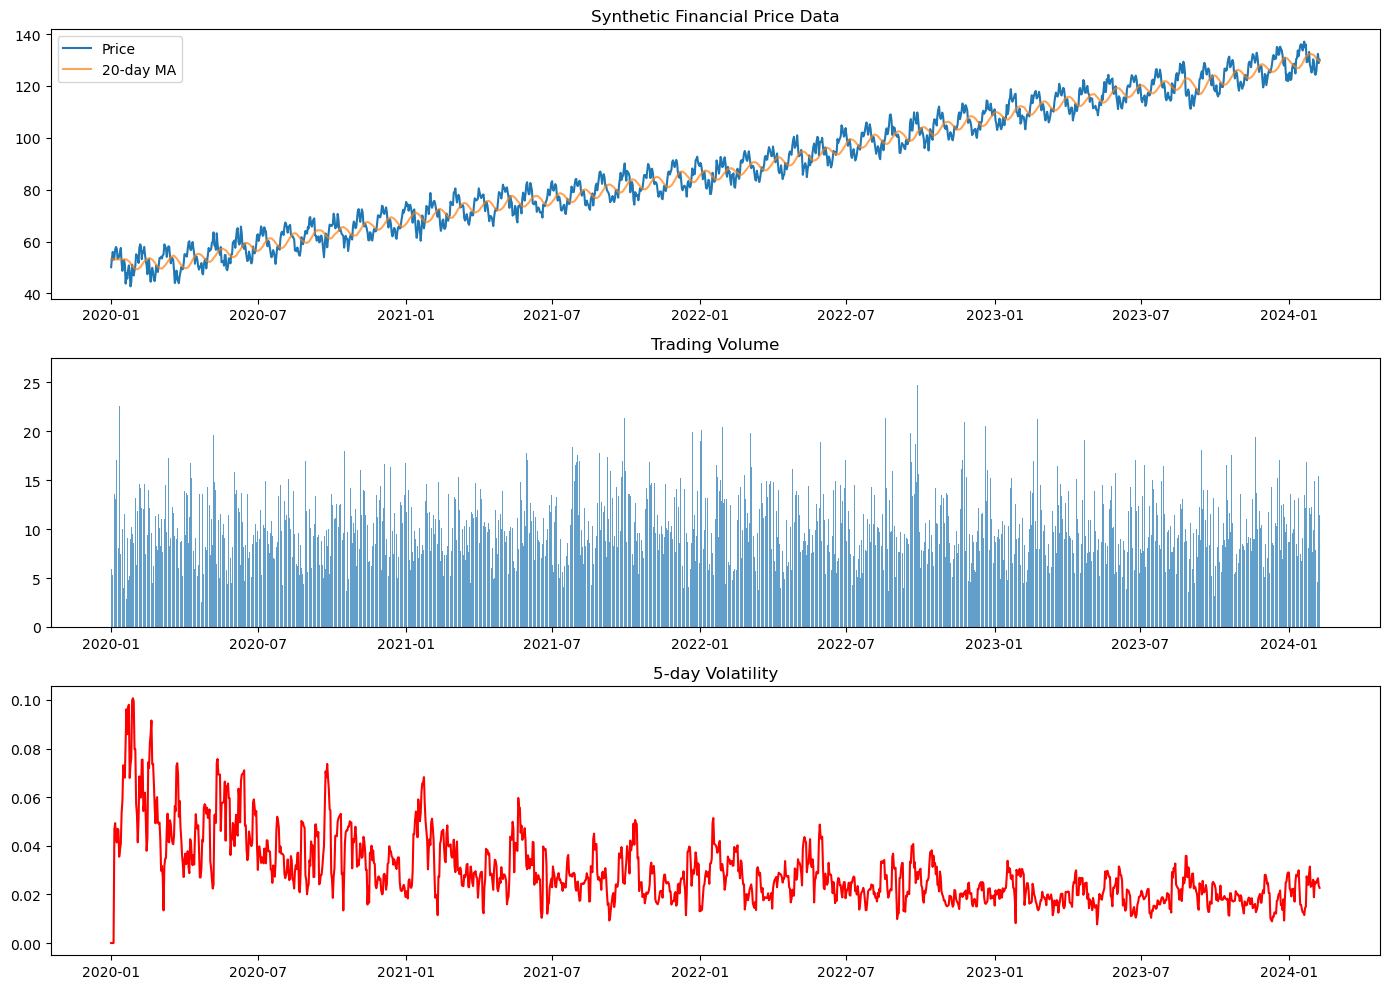

Preparing TFT data...
Creating train/test datasets...
Training set size: 1172
Test set size: 294
Creating TFT model...


TypeError: TemporalFusionTransformer.__init__() got an unexpected keyword argument 'num_static_vars'

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from IPython.display import display

# Import the TFT model - adjust the path as needed
from models.tft_v2 import TemporalFusionTransformer

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model parameters
hidden_dim = 64
lstm_layers = 1
num_heads = 4
dropout = 0.1
batch_size = 32
epochs = 50
learning_rate = 0.001

# Data parameters
backcast_length = 30  # Number of historical time steps (lookback window)
forecast_horizon = 5  # Number of future time steps to predict
train_ratio = 0.8

# Generate synthetic financial data
def generate_synthetic_financial_data(n_samples=1000, freq='D'):
    """Generate synthetic financial time series with trend, seasonality, and noise."""
    date_range = pd.date_range(start='2020-01-01', periods=n_samples, freq=freq)
    
    # Time components
    t = np.arange(n_samples)
    
    # Trend component (with random walk)
    trend = 50 + 0.05 * t + 0.1 * np.cumsum(np.random.normal(0, 1, n_samples))
    
    # Seasonality components (daily, weekly, monthly)
    daily_pattern = 2 * np.sin(2 * np.pi * t / 5)  # 5-day cycle
    weekly_pattern = 5 * np.sin(2 * np.pi * t / 30)  # 30-day cycle
    
    # Market regime shifts (occasional shocks)
    regime_shifts = np.zeros(n_samples)
    shock_points = np.random.choice(n_samples, size=3, replace=False)
    for point in shock_points:
        regime_shifts[point:point+30] = np.random.normal(0, 5) * np.exp(-0.1 * np.arange(30))
    
    # Volatility clustering
    volatility = 1 + 0.5 * np.sin(2 * np.pi * t / 120)  # Cycle of volatility
    noise = np.random.normal(0, volatility, n_samples)
    
    # Combine all components
    price = trend + daily_pattern + weekly_pattern + regime_shifts + noise
    volume = np.random.gamma(shape=10, scale=1, size=n_samples) * (1 + 0.2 * np.sin(2 * np.pi * t / 30))
    
    # Create exogenous factors
    day_of_week = np.array([d.dayofweek for d in date_range]).reshape(-1, 1)
    month = np.array([d.month for d in date_range]).reshape(-1, 1)
    
    # Create dataframe
    df = pd.DataFrame({
        'date': date_range,
        'price': price,
        'volume': volume,
        'day_of_week': day_of_week.flatten(),
        'month': month.flatten(),
        'market_regime': np.random.choice(['bull', 'bear', 'sideways'], size=n_samples),
        'dummy_event': np.random.binomial(1, 0.05, size=n_samples)  # Rare events
    })
    
    # Add engineered features
    df['returns'] = df['price'].pct_change().fillna(0)
    df['volatility_5d'] = df['returns'].rolling(5).std().fillna(0)
    df['price_ma5'] = df['price'].rolling(5).mean().fillna(method='bfill')
    df['price_ma20'] = df['price'].rolling(20).mean().fillna(method='bfill')
    
    # One-hot encode categorical variables
    df = pd.get_dummies(df, columns=['market_regime'])
    
    return df

# Generate data
print("Generating synthetic financial data...")
df = generate_synthetic_financial_data(n_samples=1500)
print(f"Dataset shape: {df.shape}")
display(df.head())

# Plot the generated data
plt.figure(figsize=(14, 10))

# Price plot
plt.subplot(3, 1, 1)
plt.plot(df['date'], df['price'], label='Price')
plt.plot(df['date'], df['price_ma20'], label='20-day MA', alpha=0.7)
plt.title('Synthetic Financial Price Data')
plt.legend()

# Volume plot
plt.subplot(3, 1, 2)
plt.bar(df['date'], df['volume'], alpha=0.7)
plt.title('Trading Volume')

# Volatility plot
plt.subplot(3, 1, 3)
plt.plot(df['date'], df['volatility_5d'], color='red')
plt.title('5-day Volatility')

plt.tight_layout()
plt.show()

# Prepare data for TFT
def prepare_tft_data(df, backcast_length, forecast_horizon):
    """
    Prepare data for TFT model by creating historical and future windows.
    Returns static, encoder (historical), and decoder (future) data.
    """
    # Define target variable
    target_col = 'price'
    
    # Define column groups
    known_cols = ['day_of_week', 'month', 'dummy_event']  # Known in future
    unknown_cols = ['volume', 'returns', 'volatility_5d']  # Unknown in future
    static_cols = ['market_regime_bull', 'market_regime_bear', 'market_regime_sideways']  # Static features
    
    # Create empty lists to store batches
    static_inputs_list = []
    encoder_inputs_list = []
    decoder_inputs_list = []
    targets_list = []
    
    # For each valid window in the dataset
    for i in range(len(df) - backcast_length - forecast_horizon + 1):
        # Extract windows
        history_window = df.iloc[i:i+backcast_length]
        future_window = df.iloc[i+backcast_length:i+backcast_length+forecast_horizon]
        
        # Target values (future prices to predict)
        targets = future_window[target_col].values
        
        # Static features (use the mode for categorical features)
        static_features = history_window[static_cols].iloc[0].values
        
        # Encoder inputs (historical data)
        encoder_known = history_window[known_cols].values
        encoder_unknown = history_window[unknown_cols].values
        encoder_target = history_window[target_col].values.reshape(-1, 1)
        
        # Decoder inputs (future data - only known variables)
        decoder_known = future_window[known_cols].values
        
        # Append to lists
        static_inputs_list.append(static_features)
        
        # Prepare encoder inputs: [target, known features, unknown features]
        encoder_inputs_list.append([
            encoder_target,
            encoder_known,
            encoder_unknown
        ])
        
        # Prepare decoder inputs: [known future features]
        decoder_inputs_list.append([
            decoder_known
        ])
        
        targets_list.append(targets.reshape(-1, 1))
    
    return (
        static_inputs_list,
        encoder_inputs_list,
        decoder_inputs_list,
        targets_list
    )

# Preprocess data
print("Preparing TFT data...")
static_inputs_list, encoder_inputs_list, decoder_inputs_list, targets_list = prepare_tft_data(
    df, backcast_length, forecast_horizon)

# Convert to tensors and create datasets
def create_tft_datasets(static_inputs_list, encoder_inputs_list, decoder_inputs_list, targets_list):
    """Convert lists to tensors and create train/test splits."""
    
    # Define scalers for each feature group
    scalers = {
        'target': StandardScaler(),
        'encoder_known': StandardScaler(),
        'encoder_unknown': StandardScaler(),
        'decoder_known': StandardScaler(),
        'static': StandardScaler()
    }
    
    # Concatenate all batches for scaling
    all_targets = np.vstack([t for t in targets_list])
    all_static = np.vstack([s for s in static_inputs_list])
    all_encoder_known = np.vstack([e[1] for e in encoder_inputs_list])
    all_encoder_unknown = np.vstack([e[2] for e in encoder_inputs_list])
    all_decoder_known = np.vstack([d[0] for d in decoder_inputs_list])
    
    # Fit scalers
    scalers['target'].fit(all_targets.reshape(-1, 1))
    scalers['static'].fit(all_static)
    scalers['encoder_known'].fit(all_encoder_known)
    scalers['encoder_unknown'].fit(all_encoder_unknown)
    scalers['decoder_known'].fit(all_decoder_known)
    
    # Function to scale data
    def scale_data(data_list, data_type):
        scaled_list = []
        for i, data in enumerate(data_list):
            if data_type == 'target':
                scaled = scalers['target'].transform(data)
            elif data_type == 'static':
                scaled = scalers['static'].transform(data.reshape(1, -1))
            elif data_type == 'encoder':
                target = scalers['target'].transform(data[0])
                known = scalers['encoder_known'].transform(data[1])
                unknown = scalers['encoder_unknown'].transform(data[2])
                scaled = [target, known, unknown]
            elif data_type == 'decoder':
                known = scalers['decoder_known'].transform(data[0])
                scaled = [known]
            scaled_list.append(scaled)
        return scaled_list
    
    # Scale all data
    scaled_targets = scale_data(targets_list, 'target')
    scaled_static = scale_data(static_inputs_list, 'static')
    scaled_encoder = scale_data(encoder_inputs_list, 'encoder')
    scaled_decoder = scale_data(decoder_inputs_list, 'decoder')
    
    # Convert to tensors
    def list_to_tensors(data_list):
        if isinstance(data_list[0], list):
            return [torch.tensor(np.stack(d), dtype=torch.float32) for d in zip(*data_list)]
        else:
            return torch.tensor(np.stack(data_list), dtype=torch.float32)
    
    targets_tensor = torch.tensor(np.stack(scaled_targets), dtype=torch.float32)
    static_tensor = torch.tensor(np.stack(scaled_static), dtype=torch.float32)
    
    # For encoder and decoder, we need to process each component separately
    encoder_tensors = []
    for i in range(len(scaled_encoder[0])):
        encoder_tensors.append(torch.tensor(np.stack([e[i] for e in scaled_encoder]), dtype=torch.float32))
    
    decoder_tensors = []
    for i in range(len(scaled_decoder[0])):
        decoder_tensors.append(torch.tensor(np.stack([d[i] for d in scaled_decoder]), dtype=torch.float32))
    
    # Split into train and test sets
    train_size = int(len(targets_tensor) * train_ratio)
    
    train_static = static_tensor[:train_size]
    test_static = static_tensor[train_size:]
    
    train_encoder = [tensor[:train_size] for tensor in encoder_tensors]
    test_encoder = [tensor[train_size:] for tensor in encoder_tensors]
    
    train_decoder = [tensor[:train_size] for tensor in decoder_tensors]
    test_decoder = [tensor[train_size:] for tensor in decoder_tensors]
    
    train_targets = targets_tensor[:train_size]
    test_targets = targets_tensor[train_size:]
    
    return (
        (train_static, train_encoder, train_decoder, train_targets),
        (test_static, test_encoder, test_decoder, test_targets),
        scalers
    )

# Create datasets
print("Creating train/test datasets...")
train_data, test_data, scalers = create_tft_datasets(
    static_inputs_list, encoder_inputs_list, decoder_inputs_list, targets_list)

# Unpack the data
train_static, train_encoder, train_decoder, train_targets = train_data
test_static, test_encoder, test_decoder, test_targets = test_data

print(f"Training set size: {len(train_targets)}")
print(f"Test set size: {len(test_targets)}")

# Create the TFT model
print("Creating TFT model...")
model = TemporalFusionTransformer(
    num_static_vars=len(static_inputs_list[0]),
    static_input_sizes=[len(static_inputs_list[0])],
    encoder_input_sizes=[1, train_encoder[1].shape[2], train_encoder[2].shape[2]],
    decoder_input_sizes=[train_decoder[0].shape[2]],
    hidden_dim=hidden_dim,
    lstm_layers=lstm_layers,
    dropout=dropout,
    num_heads=num_heads,
    forecast_horizon=forecast_horizon,
    backcast_length=backcast_length,
    output_dim=1,
    quantiles=[0.1, 0.5, 0.9]
).to(device)

# Create data loaders
def create_dataloader(static, encoder, decoder, targets, batch_size, shuffle=True):
    dataset = torch.utils.data.TensorDataset(
        static,
        *encoder,
        *decoder,
        targets
    )
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = create_dataloader(
    train_static, train_encoder, train_decoder, train_targets, batch_size)
test_loader = create_dataloader(
    test_static, test_encoder, test_decoder, test_targets, batch_size, shuffle=False)

# Define quantile loss function
def quantile_loss(preds, targets, quantiles):
    """
    Compute quantile loss for multiple quantiles.
    Args:
        preds: Tensor of shape [batch_size, seq_len, 1, num_quantiles]
        targets: Tensor of shape [batch_size, seq_len, 1]
        quantiles: List of quantiles
    """
    losses = []
    for i, q in enumerate(quantiles):
        errors = targets - preds[:, :, :, i]
        losses.append(torch.max((q-1) * errors, q * errors).mean())
    return torch.mean(torch.stack(losses))

# Training function
def train_model(model, train_loader, test_loader, epochs, lr, quantiles=[0.1, 0.5, 0.9]):
    """Train the TFT model and evaluate on test set."""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            static_batch = batch[0].to(device)
            encoder_batch = [tensor.to(device) for tensor in batch[1:4]]
            decoder_batch = [tensor.to(device) for tensor in batch[4:5]]
            targets_batch = batch[5].to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(
                static_inputs=[static_batch],
                encoder_inputs=encoder_batch,
                decoder_inputs=decoder_batch
            )
            
            # Compute loss
            loss = quantile_loss(outputs, targets_batch, quantiles)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Evaluation
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                static_batch = batch[0].to(device)
                encoder_batch = [tensor.to(device) for tensor in batch[1:4]]
                decoder_batch = [tensor.to(device) for tensor in batch[4:5]]
                targets_batch = batch[5].to(device)
                
                outputs = model(
                    static_inputs=[static_batch],
                    encoder_inputs=encoder_batch,
                    decoder_inputs=decoder_batch
                )
                
                test_loss += quantile_loss(outputs, targets_batch, quantiles).item()
        
        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        
        # Scheduler step
        scheduler.step(avg_test_loss)
        
        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
    
    return train_losses, test_losses

# Train the model
print("\nTraining TFT model...")
train_losses, test_losses = train_model(
    model, train_loader, test_loader, epochs, learning_rate)

# Plot training/test loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('TFT Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the model checkpoint
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    'scalers': scalers
}, 'tft_model_checkpoint.pth')

print("Model training completed and checkpoint saved.")

In [11]:
# TFT Testing and Visualization - Part 2
# This notebook assumes you've already run Part 1 for data preparation and model training

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from IPython.display import display

# # Load the saved model and data
# checkpoint = torch.load('tft_model_checkpoint.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# scalers = checkpoint['scalers']

# Set model to evaluation mode
model.eval()

# Define a function to make predictions and collect attention weights and variable selection weights
def predict_with_interpretation(model, static, encoder, decoder, device):
    """
    Make predictions with the TFT model and collect interpretability information.
    Returns:
        - predictions: model output
        - variable_weights: variable selection weights
        - attention_weights: temporal attention weights
    """
    # Modified Variable Selection Network to return weights
    def get_variable_selection_weights(model, x, context=None):
        batch_size, seq_len = x[0].size(0), x[0].size(1)
        
        # Static context
        if hasattr(model, 'static_vsn') and context is not None:
            static_context = context
        else:
            static_context = None
            
        # Store weights for encoder and decoder
        encoder_weights = {}
        decoder_weights = {}
        
        # Encoder variable selection (historical)
        if hasattr(model, 'encoder_vsn'):
            # Variable selection for encoder (historical)
            static_context_expanded = static_context.unsqueeze(1).expand(-1, seq_len, -1) if static_context is not None else None
            _, weights = model.encoder_vsn(x, static_context_expanded)
            encoder_weights = weights.detach().cpu()
            
        # Decoder variable selection (future)
        if hasattr(model, 'decoder_vsn'):
            # Variable selection for decoder (future)
            static_context_expanded = static_context.unsqueeze(1).expand(-1, seq_len, -1) if static_context is not None else None
            _, weights = model.decoder_vsn(x, static_context_expanded)
            decoder_weights = weights.detach().cpu()
            
        return encoder_weights, decoder_weights
    
    # Helper function to wrap encoder and decoder calls to get attention weights
    def get_attention_weights(model, static_input, encoder_input, decoder_input):
        """Extract attention weights from model."""
        # Process static variables
        static_context = None
        if static_input is not None and len(static_input) > 0 and hasattr(model, 'static_vsn'):
            static_input_seq = [x.unsqueeze(1) for x in static_input]
            static_embedding, _ = model.static_vsn(static_input_seq)
            static_context = static_embedding.squeeze(1)
            
        # Process encoder inputs
        encoder_output = None
        batch_size = encoder_input[0].size(0)
        
        if encoder_input and len(encoder_input) > 0 and hasattr(model, 'encoder_vsn'):
            static_context_expanded = static_context.unsqueeze(1).expand(-1, model.backcast_length, -1) if static_context is not None else None
            encoder_embedding, _ = model.encoder_vsn(encoder_input, static_context_expanded)
            encoder_output, (h_n, c_n) = model.lstm_encoder(encoder_embedding)
        else:
            h_n = torch.zeros(1, batch_size, model.hidden_dim, device=decoder_input[0].device)
            c_n = torch.zeros(1, batch_size, model.hidden_dim, device=decoder_input[0].device)
            
        # Process decoder inputs
        if decoder_input and len(decoder_input) > 0 and hasattr(model, 'decoder_vsn'):
            static_context_expanded = static_context.unsqueeze(1).expand(-1, model.forecast_horizon, -1) if static_context is not None else None
            decoder_embedding, _ = model.decoder_vsn(decoder_input, static_context_expanded)
            decoder_output, _ = model.lstm_decoder(decoder_embedding, (h_n, c_n))
            
            if encoder_output is not None:
                # Combine encoder and decoder outputs
                lstm_output = torch.cat([encoder_output, decoder_output], dim=1)
                
                # Modified attention module to save weights
                query = model.attention.query_proj(lstm_output)
                key = model.attention.key_proj(lstm_output)
                value = model.attention.value_proj(lstm_output)
                
                # Extract attention weights 
                batch_size = query.size(0)
                head_dim = model.hidden_dim // model.attention.num_heads
                
                # Reshape Q, K, V for multi-head
                Q = query.view(batch_size, -1, model.attention.num_heads, head_dim).transpose(1, 2)
                K = key.view(batch_size, -1, model.attention.num_heads, head_dim).transpose(1, 2)
                V = value.view(batch_size, -1, model.attention.num_heads, head_dim).transpose(1, 2)
                
                # Compute attention scores and weights
                scores = torch.matmul(Q, K.transpose(2, 3)) / (head_dim ** 0.5)
                attn_weights = torch.softmax(scores, dim=-1)  # [batch, heads, tgt_len, src_len]
                
                return attn_weights.detach().cpu()
        
        # If we couldn't calculate attention weights
        return None
    
    # Forward pass with the model
    model.eval()
    with torch.no_grad():
        # Prepare inputs
        static_inputs = [static.to(device)] if static is not None else None
        encoder_inputs = [e.to(device) for e in encoder]
        decoder_inputs = [d.to(device) for d in decoder]
        
        # Get variable selection weights
        encoder_weights, decoder_weights = get_variable_selection_weights(
            model, encoder_inputs, static_inputs[0] if static_inputs else None)
        
        # Get attention weights
        attention_weights = get_attention_weights(model, static_inputs, encoder_inputs, decoder_inputs)
        
        # Get forecasts
        outputs = model(static_inputs=static_inputs, encoder_inputs=encoder_inputs, decoder_inputs=decoder_inputs)
        
        return outputs.cpu(), encoder_weights, decoder_weights, attention_weights

# Make predictions on test data
all_predictions = []
all_encoder_weights = []
all_decoder_weights = []
all_attention_weights = []

print("Making predictions and collecting interpretation data...")
with torch.no_grad():
    for batch in test_loader:
        static_batch = batch[0]
        encoder_batch = batch[1:4]
        decoder_batch = batch[4:5]
        
        predictions, encoder_weights, decoder_weights, attention_weights = predict_with_interpretation(
            model, static_batch, encoder_batch, decoder_batch, device)
        
        all_predictions.append(predictions)
        
        if encoder_weights is not None:
            all_encoder_weights.append(encoder_weights)
        
        if decoder_weights is not None:
            all_decoder_weights.append(decoder_weights)
            
        if attention_weights is not None:
            all_attention_weights.append(attention_weights)

# Concatenate all batches
predictions = torch.cat(all_predictions, dim=0)
if all_encoder_weights:
    encoder_weights = torch.cat(all_encoder_weights, dim=0)
if all_decoder_weights:
    decoder_weights = torch.cat(all_decoder_weights, dim=0)
if all_attention_weights:
    attention_weights = torch.cat(all_attention_weights, dim=0)

# Extract P10, P50, and P90 forecasts
p10_forecast = predictions[:, :, :, 0].numpy()
p50_forecast = predictions[:, :, :, 1].numpy()  # Median forecast
p90_forecast = predictions[:, :, :, 2].numpy()

# Get actual values
test_targets_np = test_targets.numpy()

# Inverse transform to original scale
def inverse_transform_forecasts(forecasts, scaler):
    """Transform forecasts back to original scale."""
    return scaler.inverse_transform(forecasts.reshape(-1, 1)).reshape(forecasts.shape)

# Unscale predictions and targets
p10_forecast_unscaled = inverse_transform_forecasts(p10_forecast, scalers['target'])
p50_forecast_unscaled = inverse_transform_forecasts(p50_forecast, scalers['target'])
p90_forecast_unscaled = inverse_transform_forecasts(p90_forecast, scalers['target'])
test_targets_unscaled = inverse_transform_forecasts(test_targets_np, scalers['target'])

# Calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    """Calculate various forecast evaluation metrics."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape
    }

# Reshape arrays for metric calculation
y_true = test_targets_unscaled.reshape(-1)
y_pred = p50_forecast_unscaled.reshape(-1)

# Calculate metrics
metrics = calculate_metrics(y_true, y_pred)

# Print metrics
print("\nEvaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Calculate prediction interval coverage
def calculate_pi_coverage(y_true, lower_bound, upper_bound):
    """Calculate prediction interval coverage (% of true values within the interval)."""
    within_interval = np.logical_and(y_true >= lower_bound, y_true <= upper_bound)
    coverage = np.mean(within_interval) * 100
    return coverage

# Calculate P10-P90 interval coverage
pi_coverage = calculate_pi_coverage(
    test_targets_unscaled.reshape(-1),
    p10_forecast_unscaled.reshape(-1),
    p90_forecast_unscaled.reshape(-1)
)
print(f"\nP10-P90 Prediction Interval Coverage: {pi_coverage:.2f}%")

# Plot forecasts with uncertainty bands
def plot_forecasts_with_uncertainty(y_true, p10, p50, p90, num_samples=100, title='TFT Forecasts with Uncertainty'):
    """Plot forecasts with uncertainty bands for a subset of test samples."""
    plt.figure(figsize=(15, 8))
    
    # Select a subset of samples for visibility
    indices = np.arange(len(y_true))
    
    # Plot prediction intervals
    plt.fill_between(indices, p10.flatten(), p90.flatten(), alpha=0.3, color='blue', label='P10-P90 Interval')
    
    # Plot median forecast
    plt.plot(indices, p50.flatten(), 'g-', label='P50 (Median) Forecast', linewidth=2)
    
    # Plot actual values
    plt.plot(indices, y_true.flatten(), 'r-', label='Actual Values', linewidth=1)
    
    plt.title(title)
    plt.legend()
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot a subset of forecasts
plot_forecasts_with_uncertainty(
    test_targets_unscaled[:100], 
    p10_forecast_unscaled[:100], 
    p50_forecast_unscaled[:100], 
    p90_forecast_unscaled[:100],
    title='TFT Forecasts with P10-P90 Uncertainty Intervals'
)

# Visualize variable importance
def plot_variable_importance(encoder_weights, feature_names=None):
    """Plot variable selection weights to show feature importance."""
    if feature_names is None:
        feature_names = ['Target', 'Known', 'Unknown']
    
    # Average weights across all samples and time steps
    avg_weights = encoder_weights.mean(dim=(0, 1)).numpy()
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(feature_names, avg_weights)
    
    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f}', ha='center', va='bottom')
    
    plt.title('Variable Importance (Average Selection Weights)')
    plt.ylabel('Average Weight')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(avg_weights) * 1.2)
    plt.tight_layout()
    plt.show()

# Plot variable importance for encoder features
if 'encoder_weights' in locals():
    print("\nVariable Importance Analysis:")
    plot_variable_importance(encoder_weights)

# Visualize temporal attention patterns
def plot_attention_patterns(attention_weights, num_samples=5):
    """Plot temporal attention patterns to show how the model attends to different time steps."""
    if attention_weights is None:
        print("No attention weights available to visualize.")
        return
    
    # Select a few samples to visualize
    sample_indices = np.random.choice(attention_weights.shape[0], min(num_samples, attention_weights.shape[0]), replace=False)
    
    # For each sample, average across attention heads
    avg_attention = attention_weights[sample_indices].mean(dim=1).numpy()
    
    # Plot attention weights
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(sample_indices):
        plt.subplot(num_samples, 1, i+1)
        
        # Plot attention heatmap
        sns.heatmap(avg_attention[i], cmap='viridis', 
                   xticklabels=5, yticklabels=5)
        
        # Add vertical line to separate encoder and decoder time steps
        plt.axvline(x=backcast_length, color='red', linestyle='--')
        
        plt.title(f'Sample {idx}: Temporal Attention Pattern')
        plt.xlabel('Source Time Step')
        plt.ylabel('Target Time Step')
    
    plt.tight_layout()
    plt.show()

# Plot attention patterns
if 'attention_weights' in locals():
    print("\nTemporal Attention Pattern Analysis:")
    plot_attention_patterns(attention_weights)

# Time Series Decomposition Analysis
def analyze_and_plot_tft_components(model, sample_idx=0):
    """
    Analyze how TFT processes a single sample to showcase its interpretability.
    """
    print("\nTFT Component Analysis for a Sample:")
    
    # Get a sample from test data
    sample_batch = next(iter(test_loader))
    static_sample = sample_batch[0][sample_idx:sample_idx+1].to(device)
    encoder_sample = [tensor[sample_idx:sample_idx+1].to(device) for tensor in sample_batch[1:4]]
    decoder_sample = [tensor[sample_idx:sample_idx+1].to(device) for tensor in sample_batch[4:5]]
    target_sample = sample_batch[5][sample_idx:sample_idx+1].cpu().numpy()
    
    # Original unscaled target for context
    target_unscaled = scalers['target'].inverse_transform(target_sample)
    
    # Forward pass with interpretation data
    with torch.no_grad():
        # Get model predictions with interpretation data
        predictions, encoder_weights, decoder_weights, attention_weights = predict_with_interpretation(
            model, static_sample, encoder_sample, decoder_sample, device)
        
        # Extract quantile predictions
        p10_pred = predictions[:, :, :, 0].numpy()
        p50_pred = predictions[:, :, :, 1].numpy()
        p90_pred = predictions[:, :, :, 2].numpy()
        
        # Inverse transform to original scale
        p10_unscaled = scalers['target'].inverse_transform(p10_pred.reshape(-1, 1)).reshape(p10_pred.shape)
        p50_unscaled = scalers['target'].inverse_transform(p50_pred.reshape(-1, 1)).reshape(p50_pred.shape)
        p90_unscaled = scalers['target'].inverse_transform(p90_pred.reshape(-1, 1)).reshape(p90_pred.shape)
        
        # Step 1: Plot input variables and variable selection weights
        if encoder_weights is not None:
            plt.figure(figsize=(15, 10))
            
            # Plot original input time series
            plt.subplot(3, 1, 1)
            orig_input = scalers['target'].inverse_transform(encoder_sample[0].cpu().numpy().reshape(-1, 1))
            plt.plot(orig_input, 'b-', label='Input Time Series')
            plt.title('Original Input Time Series')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend()
            
            # Plot variable selection weights over time for encoder
            plt.subplot(3, 1, 2)
            weights = encoder_weights[0].numpy()  # First sample
            feature_names = ['Target', 'Known', 'Unknown']
            
            for i, name in enumerate(feature_names):
                plt.plot(weights[:, i], label=name)
            
            plt.title('Variable Selection Weights Over Time (Encoder)')
            plt.xlabel('Time Step')
            plt.ylabel('Weight')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend()
            
            # Plot forecast with uncertainty
            plt.subplot(3, 1, 3)
            time_indices = np.arange(backcast_length, backcast_length + forecast_horizon)
            
            # Plot prediction intervals
            plt.fill_between(time_indices, 
                            p10_unscaled[0, :, 0], 
                            p90_unscaled[0, :, 0], 
                            alpha=0.3, color='blue', 
                            label='P10-P90 Interval')
            
            # Plot median forecast
            plt.plot(time_indices, p50_unscaled[0, :, 0], 'g-', 
                    label='P50 (Median) Forecast', linewidth=2)
            
            # Plot actual values
            plt.plot(time_indices, target_unscaled[0, :, 0], 'r-', 
                    label='Actual Values', linewidth=1)
            
            plt.title('Forecast with Uncertainty')
            plt.xlabel('Time Step')
            plt.ylabel('Value')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend()
            
            plt.tight_layout()
            plt.show()
        
        # Step 2: Plot attention patterns for this sample
        if attention_weights is not None:
            plt.figure(figsize=(12, 10))
            
            # Average across attention heads
            avg_attention = attention_weights[sample_idx].mean(dim=0).numpy()
            
            # Plot the attention weights
            sns.heatmap(avg_attention, cmap='viridis', 
                       xticklabels=5, yticklabels=5)
            
            # Add vertical line to separate encoder and decoder time steps
            plt.axvline(x=backcast_length, color='red', linestyle='--')
            
            plt.title('Temporal Attention Pattern')
            plt.xlabel('Source Time Step')
            plt.ylabel('Target Time Step')
            plt.tight_layout()
            plt.show()
            
            # For the last forecast step, show which past elements it attends to
            plt.figure(figsize=(12, 6))
            
            # Get attention weights for last forecast step (target_t for all sources)
            last_step_attention = avg_attention[-1, :]
            
            # Plot as a bar chart
            plt.bar(range(len(last_step_attention)), last_step_attention)
            plt.axvline(x=backcast_length, color='red', linestyle='--', 
                      label='History/Future Boundary')
            
            plt.title('Attention Weights for Final Forecast Step')
            plt.xlabel('Source Time Step')
            plt.ylabel('Attention Weight')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend()
            plt.tight_layout()
            plt.show()

# Analyze TFT components for a sample
analyze_and_plot_tft_components(model)

# Compute and plot the correlation between inputs and forecast
def analyze_input_forecast_correlation():
    """Analyze how different input variables correlate with forecast accuracy."""
    print("\nAnalyzing Input-Forecast Correlation:")
    
    # Get all test data in original scale
    all_encoder_inputs = []
    all_targets = []
    all_forecasts = []
    all_errors = []
    
    with torch.no_grad():
        for batch in test_loader:
            static_batch = batch[0].to(device)
            encoder_batch = [tensor.to(device) for tensor in batch[1:4]]
            decoder_batch = [tensor.to(device) for tensor in batch[4:5]]
            targets_batch = batch[5].numpy()
            
            # Get model predictions
            outputs = model(
                static_inputs=[static_batch],
                encoder_inputs=encoder_batch,
                decoder_inputs=decoder_batch
            ).cpu().numpy()
            
            # Extract median forecast (p50)
            p50_forecast = outputs[:, :, :, 1]
            
            # Calculate forecast errors
            errors = np.abs(p50_forecast - targets_batch)
            
            # Inverse transform inputs and targets
            encoder_price = scalers['target'].inverse_transform(encoder_batch[0].cpu().numpy().reshape(-1, 1))
            encoder_known = scalers['encoder_known'].inverse_transform(encoder_batch[1].cpu().numpy().reshape(-1, encoder_batch[1].shape[-1]))
            encoder_unknown = scalers['encoder_unknown'].inverse_transform(encoder_batch[2].cpu().numpy().reshape(-1, encoder_batch[2].shape[-1]))
            
            # Store original inputs and errors
            all_encoder_inputs.append(np.concatenate([
                encoder_price.reshape(encoder_batch[0].shape[0], encoder_batch[0].shape[1], -1),
                encoder_known.reshape(encoder_batch[1].shape[0], encoder_batch[1].shape[1], -1),
                encoder_unknown.reshape(encoder_batch[2].shape[0], encoder_batch[2].shape[1], -1)
            ], axis=2))
            
            all_targets.append(scalers['target'].inverse_transform(targets_batch.reshape(-1, 1)).reshape(targets_batch.shape))
            all_forecasts.append(scalers['target'].inverse_transform(p50_forecast.reshape(-1, 1)).reshape(p50_forecast.shape))
            all_errors.append(errors)
    
    # Concatenate all batches
    all_encoder_inputs = np.concatenate(all_encoder_inputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    all_forecasts = np.concatenate(all_forecasts, axis=0)
    all_errors = np.concatenate(all_errors, axis=0)
    
    # Calculate mean absolute error for each sample
    mae_per_sample = np.mean(np.abs(all_forecasts - all_targets), axis=(1, 2))
    
    # Calculate statistical properties of input time series
    input_stats = []
    feature_names = ['Price', 'Day of Week', 'Month', 'Event Flag', 
                     'Volume', 'Returns', 'Volatility']
    
    # For each sample, calculate statistics of the input time series
    for i in range(all_encoder_inputs.shape[0]):
        sample_stats = {}
        
        # For each feature, calculate statistics
        for j in range(all_encoder_inputs.shape[2]):
            feature_values = all_encoder_inputs[i, :, j]
            feature_name = feature_names[j] if j < len(feature_names) else f'Feature_{j}'
            
            sample_stats[f'{feature_name}_mean'] = np.mean(feature_values)
            sample_stats[f'{feature_name}_std'] = np.std(feature_values)
            sample_stats[f'{feature_name}_min'] = np.min(feature_values)
            sample_stats[f'{feature_name}_max'] = np.max(feature_values)
            
            # Additional for price
            if j == 0:  # Price feature
                # Calculate trend as regression slope
                x = np.arange(len(feature_values))
                slope, _ = np.polyfit(x, feature_values, 1)
                sample_stats['Price_trend'] = slope
                
                # Calculate volatility ratio
                sample_stats['Price_volatility_ratio'] = np.std(feature_values) / np.mean(feature_values)
        
        input_stats.append(sample_stats)
    
    # Convert to DataFrame
    stats_df = pd.DataFrame(input_stats)
    
    # Add MAE
    stats_df['MAE'] = mae_per_sample
    
    # Calculate correlation with MAE
    corr_with_mae = stats_df.corr()['MAE'].sort_values(ascending=False)
    
    # Plot correlations
    plt.figure(figsize=(12, 8))
    corr_with_mae = corr_with_mae.drop('MAE')  # Drop self-correlation
    
    top_n = 10
    top_corrs = corr_with_mae.abs().nlargest(top_n)
    colors = ['g' if x >= 0 else 'r' for x in corr_with_mae[top_corrs.index]]
    
    plt.barh(top_corrs.index, corr_with_mae[top_corrs.index], color=colors)
    plt.title(f'Top {top_n} Input Features Correlated with Forecast Error (MAE)')
    plt.xlabel('Correlation Coefficient')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Plot a scatter plot of the top correlated feature
    top_feature = top_corrs.index[0]
    plt.figure(figsize=(10, 6))
    plt.scatter(stats_df[top_feature], stats_df['MAE'], alpha=0.5)
    plt.title(f'Relationship between {top_feature} and Forecast Error')
    plt.xlabel(top_feature)
    plt.ylabel('Mean Absolute Error')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return stats_df

# Analyze correlation between inputs and forecast errors
input_forecast_stats = analyze_input_forecast_correlation()

# Plot variable importance over time
def plot_variable_importance_over_time():
    """Plot how variable importance changes over time."""
    print("\nVariable Importance Evolution Over Time:")
    
    if 'encoder_weights' not in locals():
        print("No encoder weights available to visualize.")
        return
    
    # Average across all samples
    avg_weights = encoder_weights.mean(dim=0).numpy()
    
    # Feature names
    feature_names = ['Target', 'Known', 'Unknown']
    
    plt.figure(figsize=(12, 6))
    
    # Plot weight evolution over time
    for i, name in enumerate(feature_names):
        plt.plot(range(avg_weights.shape[0]), avg_weights[:, i], label=name)
    
    plt.title('Variable Importance Evolution Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Average Selection Weight')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot variable importance over time
plot_variable_importance_over_time()

# Compare different forecast horizons
def compare_forecast_horizons():
    """Compare forecast accuracy across different forecast horizons."""
    print("\nComparing Forecast Accuracy Across Horizons:")
    
    # Calculate error metrics for each horizon
    horizon_metrics = []
    
    for h in range(forecast_horizon):
        y_true = test_targets_unscaled[:, h, :].reshape(-1)
        y_pred = p50_forecast_unscaled[:, h, :].reshape(-1)
        p10 = p10_forecast_unscaled[:, h, :].reshape(-1)
        p90 = p90_forecast_unscaled[:, h, :].reshape(-1)
        
        # Calculate metrics
        metrics = calculate_metrics(y_true, y_pred)
        
        # Add prediction interval coverage
        pi_coverage = calculate_pi_coverage(y_true, p10, p90)
        metrics['PI Coverage (%)'] = pi_coverage
        
        # Add horizon
        metrics['Horizon'] = h + 1
        
        horizon_metrics.append(metrics)
    
    # Convert to DataFrame for easy plotting
    metrics_df = pd.DataFrame(horizon_metrics)
    
    # Plot
    plt.figure(figsize=(15, 10))
    
    # Plot RMSE by horizon
    plt.subplot(2, 2, 1)
    plt.plot(metrics_df['Horizon'], metrics_df['RMSE'], 'o-')
    plt.title('RMSE by Forecast Horizon')
    plt.xlabel('Forecast Horizon')
    plt.ylabel('RMSE')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot MAE by horizon
    plt.subplot(2, 2, 2)
    plt.plot(metrics_df['Horizon'], metrics_df['MAE'], 'o-')
    plt.title('MAE by Forecast Horizon')
    plt.xlabel('Forecast Horizon')
    plt.ylabel('MAE')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot MAPE by horizon
    plt.subplot(2, 2, 3)
    plt.plot(metrics_df['Horizon'], metrics_df['MAPE (%)'], 'o-')
    plt.title('MAPE by Forecast Horizon')
    plt.xlabel('Forecast Horizon')
    plt.ylabel('MAPE (%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # # Plot PI Coverage by horizon
    # plt.subplot(2, 2, 4)
    # plt.plot(metrics_df['Horizon'], metrics_df['PI Coverage (%)'], 'o-')
    # plt.axhline(y=80, color='r', linestyle='--', label='80% Target')
    # plt.title('P10-P90

Making predictions and collecting interpretation data...


NameError: name 'test_loader' is not defined